 # NUMERICAL MATHEMATICAL MODELS FOR STOCK PRICE ESTIMATION

## Historical Stock Data Acquisition

In the scope of this article, the company we are interested in is Apple Inc. (AAPL). Our time horizon is more than 20 years, starting from 01/06/2002 till 03/08/2022. *yFinance* will be used to acquire this stock data. *yFinance* is an open-source tool that use Yahoo's publicly available APIs. It offers a way to download market data from https://finance.yahoo.com/ without any charge.

## Prerequitesite Python Packages

In [1]:
# Import required Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

from pathlib import Path
from warnings import simplefilter

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.ar_model import AR
from  statsmodels.tsa.ar_model import AutoReg as AR 
import seaborn as sns


In [2]:
start_date = dt.date(2002,6,1)
end_date = dt.date(2022,8,3)
stock_data = yf.download('AAPL',start_date,end_date)

[*********************100%***********************]  1 of 1 completed


We will divide our data into 2 data sets: training (from 31/05/2002 to 01/08/2021) and prediction (from 02/08/2021 to 02/08/2022)

In [3]:
# Time-step feature
"""
Provided the time series doesn't have any missing dates, we can create a time dummy by 
counting out the length of the series.
"""
stock_data['Time'] = list(np.arange(len(stock_data.index)))

The stock is stated as `Close Price` and `Adj Close`. The adjusted close is the amended price from the close price already reflecting the corporate actions such as stock splits, dividends, and rights offerings. Therefore, we will use `Adj Close` for our calculation.

In [4]:
stock_data = stock_data.loc[:,['Adj Close','Time']]
stock_data

Adj Close  Time
Date                        
2002-05-31    0.355255     0
2002-06-03    0.349309     1
2002-06-04    0.347327     2
2002-06-05    0.346411     3
2002-06-06    0.337873     4
...                ...   ...
2022-07-27  156.572510  5074
2022-07-28  157.131744  5075
2022-07-29  162.284576  5076
2022-08-01  161.285965  5077
2022-08-02  159.788040  5078

[5079 rows x 2 columns]

In [5]:
end_training_date = dt.date(2021,8,1)
stock_data_train = stock_data.loc[:'2021-08-01',:]

stock_data_prediction = stock_data.loc['2021-08-01':,:]

In [6]:
stock_data['Adj Close'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 5079 entries, 2002-05-31 to 2022-08-02
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
5079 non-null   float64
dtypes: float64(1)
memory usage: 208.4 KB



Firstly, let's have a look at the AAPL stock price over 20 years.

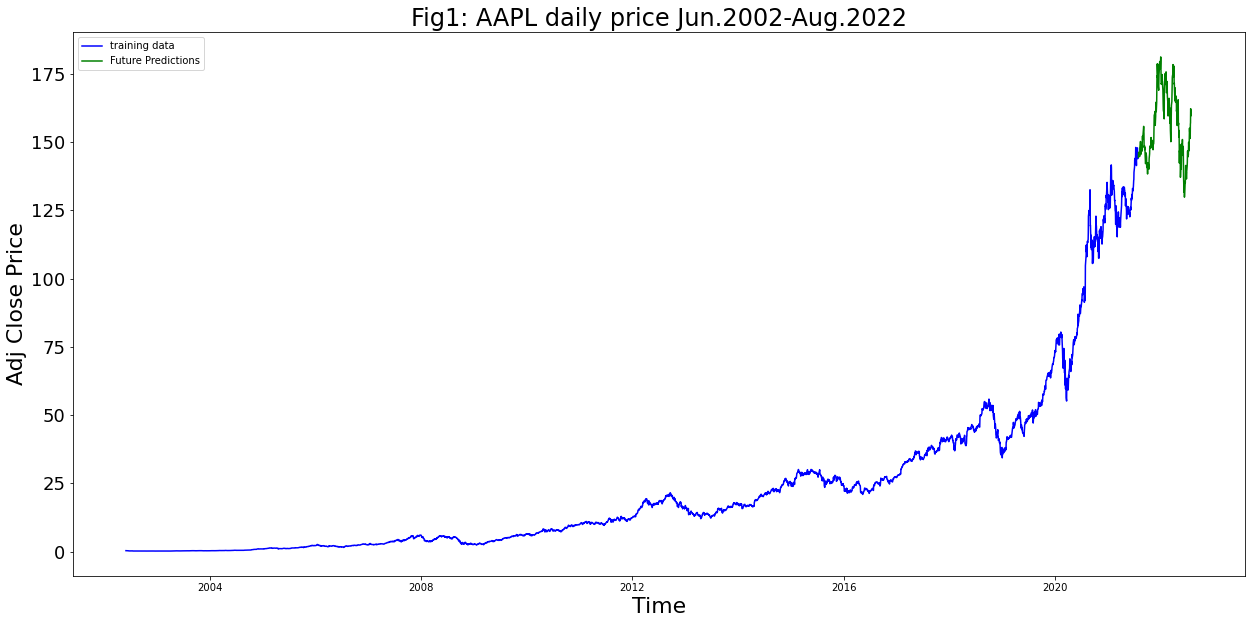

In [7]:
#  plot AAPL stock price over 10 years (0.6/2012-0.6/2022)
Ta=10 #Number of time unit
plt.figure(figsize=(21, 10))
plt.title('Fig1: AAPL daily price Jun.2002-Aug.2022', fontsize=24)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Adj Close Price', fontsize=22)
plt.yticks(fontsize=18)

# stock_data_train['Adj Close'].plot()
# stock_data_prediction['Adj Close'].plot()
plt.plot(stock_data_train['Adj Close'], color='b', label='training data')
plt.plot(stock_data_prediction['Adj Close'], color='g', label='Future Predictions')
plt.legend()
plt.show()

## Method 1: Linear regression


In [8]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [9]:
stock_data_train=stock_data_train['Adj Close']
stock_data_train=stock_data_train.to_frame()

In [10]:
# Time-step feature
"""
Provided the time series doesn't have any missing dates, we can create a time dummy by 
counting out the length of the series.
"""
stock_data_train['Time'] = list(np.arange(len(stock_data_train.index)))


In [11]:
stock_data_train

Adj Close  Time
Date                        
2002-05-31    0.355255     0
2002-06-03    0.349309     1
2002-06-04    0.347327     2
2002-06-05    0.346411     3
2002-06-06    0.337873     4
...                ...   ...
2021-07-26  147.938141  4821
2021-07-27  145.733780  4822
2021-07-28  143.956436  4823
2021-07-29  144.611786  4824
2021-07-30  144.830231  4825

[4826 rows x 2 columns]

In [12]:
stock_data_prediction.shape

(253, 2)

In [13]:
# Training data
X = stock_data_train.loc[:, ['Time']] 
y = stock_data_train.loc[:, 'Adj Close'] 


X_pred = np.asarray(pd.RangeIndex(start=stock_data_train['Time'][-1], 
                                  stop = stock_data_train['Time'][-1]+stock_data_prediction.shape[0]))
# Train the model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)


# Store the fitted values as a time series with the same time index as
# the training data
y_trend_train = pd.Series(model.predict(X), index=X.index)
y_trend_pred = pd.Series(model.predict(X_pred.reshape(-1, 1)), index=stock_data_prediction.index)

In [14]:
y_trend_train

Date
2002-05-31     0.000000
2002-06-03     0.011539
2002-06-04     0.023078
2002-06-05     0.034617
2002-06-06     0.046156
                ...    
2021-07-26    55.629152
2021-07-27    55.640691
2021-07-28    55.652230
2021-07-29    55.663769
2021-07-30    55.675308
Length: 4826, dtype: float64

In [15]:
linear_reg=list(pd.concat([y_trend_train,y_trend_pred],axis=0).reset_index(drop=True))
stock_data['linear_reg'] = linear_reg
stock_data

Adj Close  Time  linear_reg
Date                                    
2002-05-31    0.355255     0    0.000000
2002-06-03    0.349309     1    0.011539
2002-06-04    0.347327     2    0.023078
2002-06-05    0.346411     3    0.034617
2002-06-06    0.337873     4    0.046156
...                ...   ...         ...
2022-07-27  156.572510  5074   58.536961
2022-07-28  157.131744  5075   58.548500
2022-07-29  162.284576  5076   58.560039
2022-08-01  161.285965  5077   58.571578
2022-08-02  159.788040  5078   58.583117

[5079 rows x 3 columns]

In [16]:
#display regression coefficients and R-squared (coefficient of determination) value of model
print("Model's linear parameters: ",model.intercept_, model.coef_)
# model evaluation
error = mean_squared_error(y, y_trend_train)
r2 = r2_score(y, y_trend_train)
print('Root mean squared error: ', error)
print('R2 score: ', r2)

Model's linear parameters:  0.0 [0.01153892]
Root mean squared error:  413.84140798025277
R2 score:  0.548039647643655


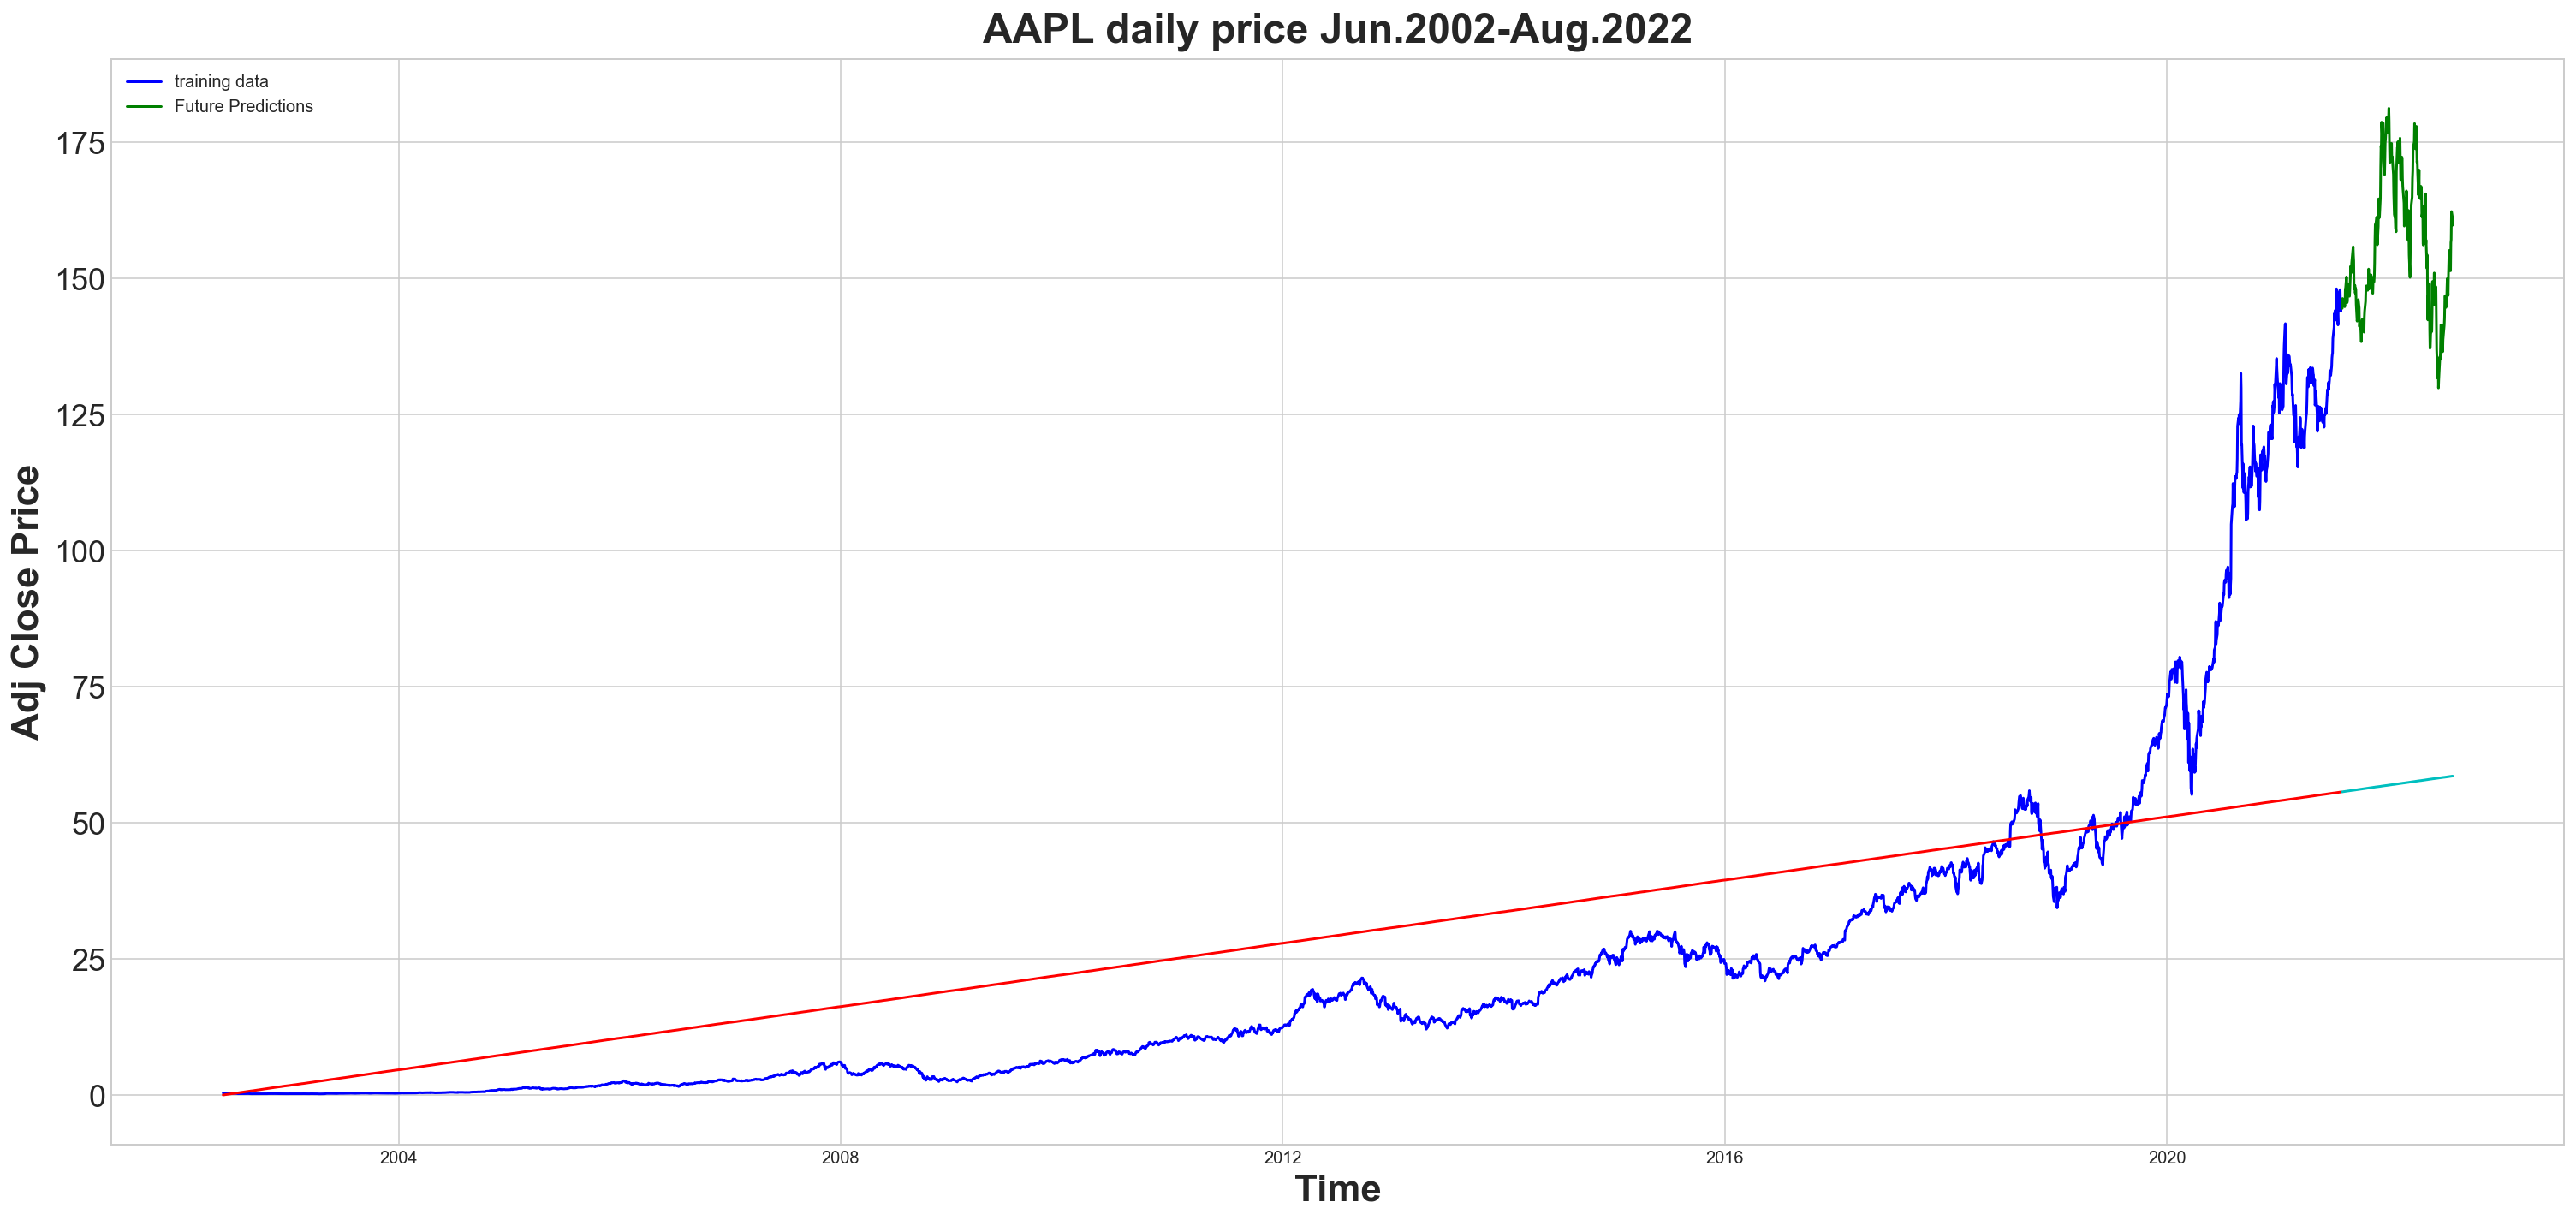

In [17]:
#  plot AAPL stock price
Ta=10 #Number of time unit
plt.figure(figsize=(21, 10))
plt.title('AAPL daily price Jun.2002-Aug.2022', fontsize=24)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Adj Close Price', fontsize=22)
plt.yticks(fontsize=18)


plt.plot(stock_data_train['Adj Close'], color='b', label='training data')
plt.plot(stock_data_prediction['Adj Close'], color='g', label='Future Predictions')
plt.plot(y_trend_train, color='r')
plt.plot(y_trend_pred, color='c')
plt.legend()
plt.show()

From the graph, we can see the significant uprising yearly trend.
However, as we can see the growth of a stock market is never linear like a line and $R^2=54.80$% therefore, we should try a higher order polynomial equations. Polynomial regression (with degree =5) fits a nonlinear relationship between the value of x and the corresponding conditional mean of y, denoted E(y |x), and has been used to describe nonlinear phenomena.

## Method 2: Polynomial regression

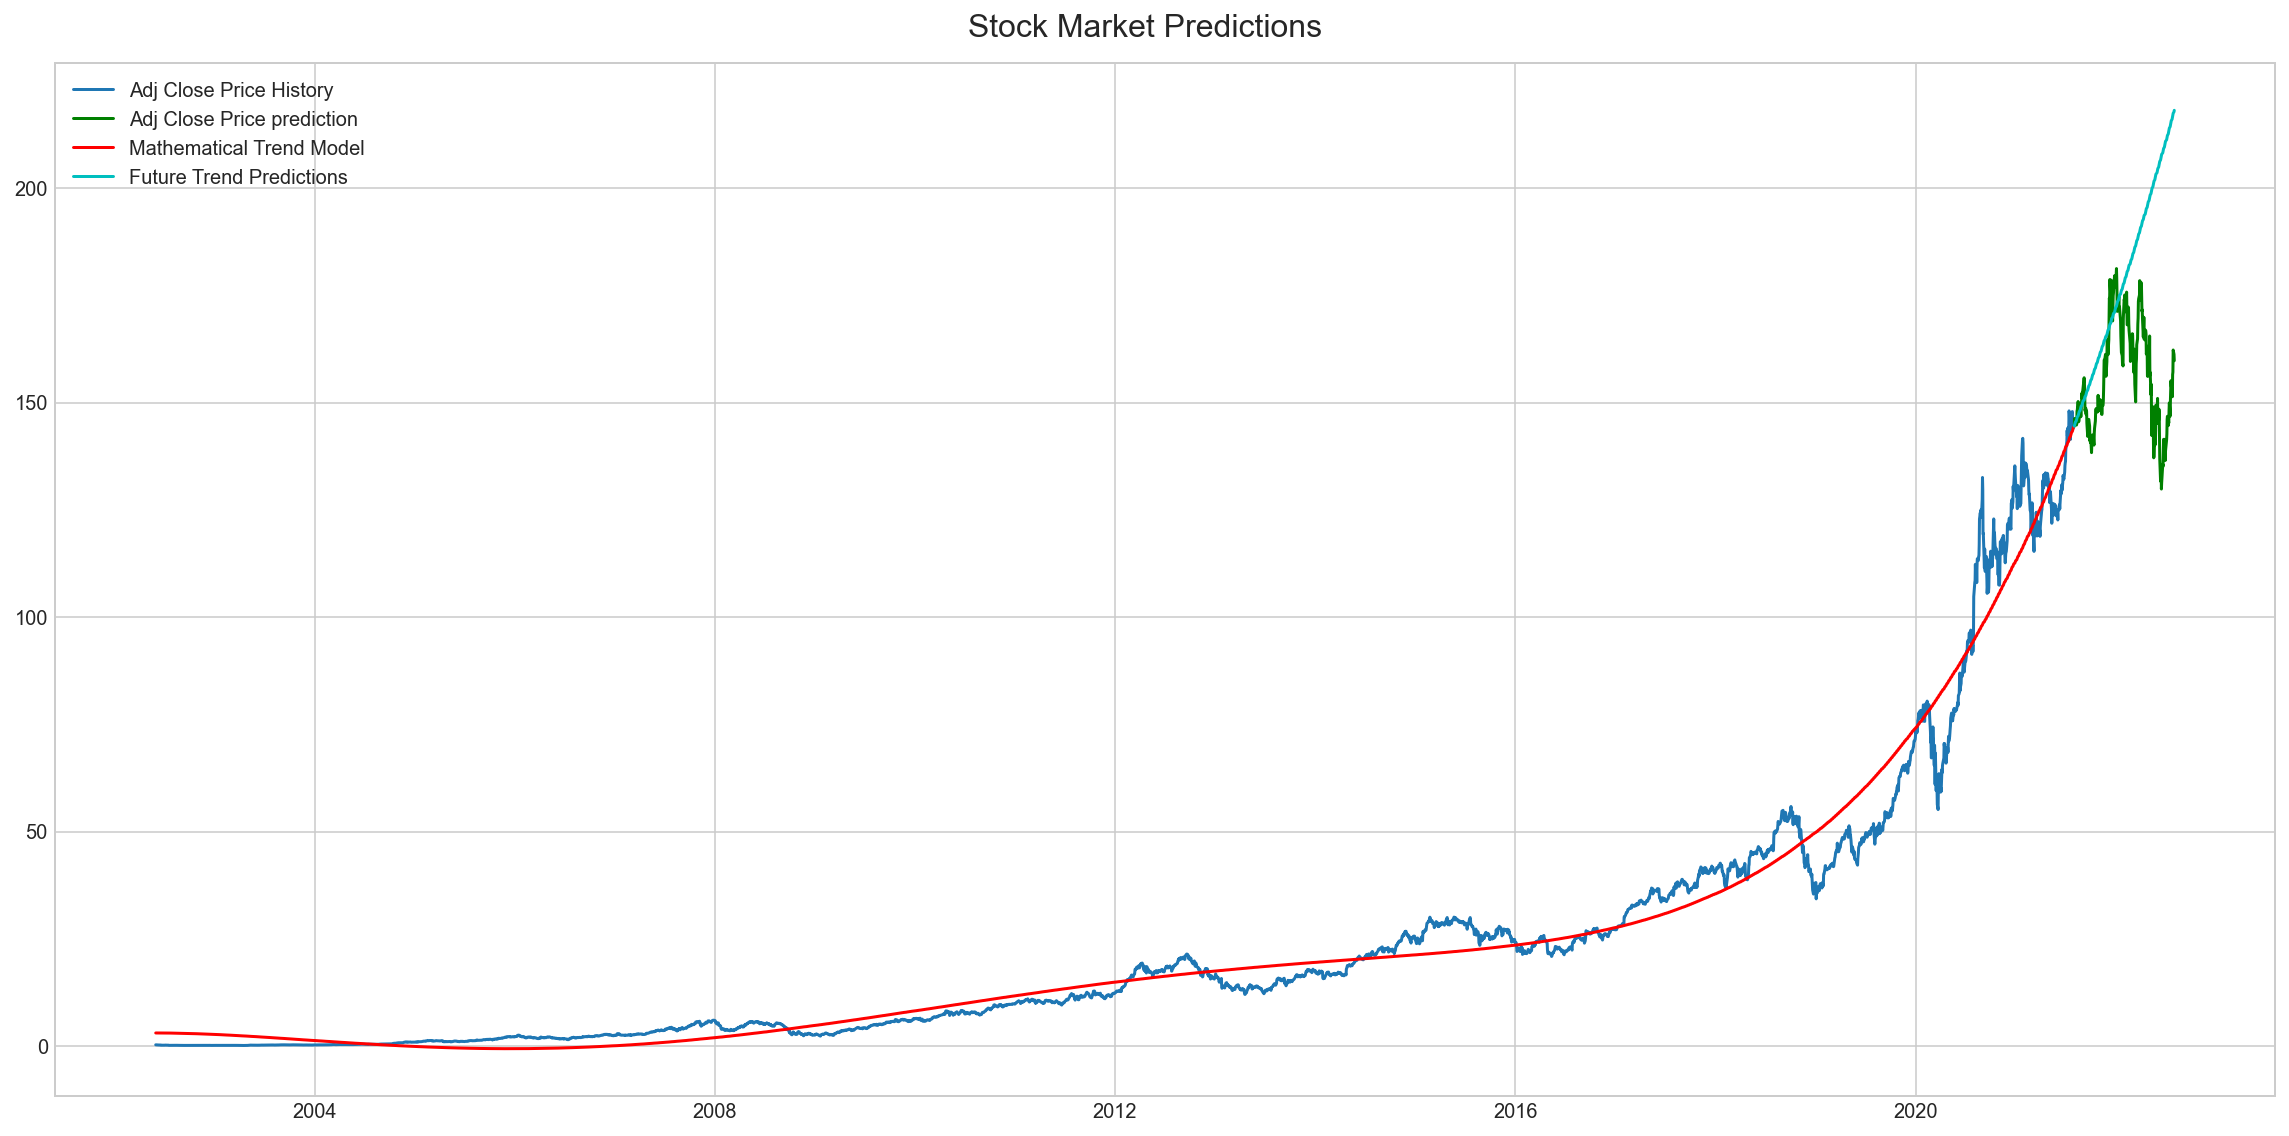

In [18]:
#Convert the pandas series into numpy array
y = np.asarray(stock_data_train['Adj Close'])
X = np.asarray(stock_data_train['Time'])


#Model initialization
#by default the degree of the equation is 1.
#Hence the mathematical model equation is y = mx + c, 
#which is an equation of a line.
regression_model = LinearRegression()

#Choose the order of your polynomial. Here the degree is set to 5.
#hence the mathematical model equation is 
#y = c0 + c1.x**1 + c2.x**2 + c3.x**3 + c4.x**4 + c5.x**5
poly = PolynomialFeatures(5)

#Convert dimension x in the higher degree polynomial expression
X_transform = poly.fit_transform(X.reshape(-1, 1))

#Fit the data(train the model)
regression_model.fit(X_transform, y.reshape(-1, 1))

# Prediction for historical dates. Let's call it learned values.
y_learned = regression_model.predict(X_transform)

newindex = np.asarray(stock_data_prediction['Time'])

#Convert the extended dimension x in the higher degree polynomial expression
X_extended_transform = poly.fit_transform(newindex.reshape(-1, 1))

#Prediction for future dates. Let's call it predicted values.
y_predict = regression_model.predict(X_extended_transform)

#Print the last predicted value
# print ("Closing price at 2023 would be around ", y_predict[-1])

#Convert the days index back to dates index for plotting the graph
X = stock_data_train.index
future_X = stock_data_prediction.index



#Setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#Plot the actual data
plt.figure(figsize=(16,8))
plt.plot(X,stock_data_train['Adj Close'], label='Adj Close Price History')
plt.plot(future_X,stock_data_prediction['Adj Close'], label='Adj Close Price prediction', color='g')


#Plot the regression model
plt.plot(X,y_learned, color='r', label='Mathematical Trend Model')

#Plot the future predictions
plt.plot(future_X,y_predict, color='c', label='Future Trend Predictions')

#Set the title of the graph
plt.suptitle('Stock Market Predictions', fontsize=16)

#Set the title of the graph window
fig = plt.gcf()
fig.canvas.set_window_title('Stock Market Predictions')

#display the legends
plt.legend()
#display the graph
plt.show()

In [19]:
# Polynomial model parameters
print("Model's polynomial parameters: ",regression_model.intercept_, regression_model.coef_)
# model evaluation
rmse = mean_squared_error(y, y_learned)
r2 = r2_score(y, y_learned)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Model's polynomial parameters:  [3.11452719] [[ 0.00000000e+00 -2.51488714e-08 -1.84707947e-05  2.14474880e-08
  -7.34482474e-12  8.19400181e-16]]
Root mean squared error:  25.065529823390442
R2 score:  0.9726256834803767


As we can see, the polynomial model provides a better forcasting results in comparision to linear regression model. The root mean squared error reduces from 413.84 (Linear regression) to 25.97 (Polynomial regression) and R-square increases from 54.80% (Linear regression) to 97.26% (Polynomial regression).

## Method 3: ARIMA model

#### ARIMA notation
ARIMA stands for autoregressive integrated moving average model and is specified by three order parameters: (P, D, Q).
* AR(P) Autoregression – P is the order of AR model. A regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(P)) component refers to the use of past values in the regression equation for the time series.
* I(D) Integration – D is the order of differencing to get the Stationery Series. Using differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.
* MA(Q) Moving Average – Q is  the order of MA model. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.

Figure out order of ARIMA model:

In [20]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [21]:
stepwise_fit=auto_arima(stock_data["Adj Close"], trace=True, suppress_warnings=True)
# stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.43 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=18235.082, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=16610.052, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=16038.293, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=15569.028, Time=0.23 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=15316.997, Time=0.32 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=15232.075, Time=0.39 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=2.13 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=15234.073, Time=0.70 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 8.721 seconds



Via the visualization of stock price over years, we can realize that our data set is not stationary as there is a significant increasing trend; therefore, its mean changes over time. However, to verify that we will run statistical test as well. Here we will run Augmented Dickey-Fuller test:

In [22]:
# check for stationary
from statsmodels.tsa.stattools import adfuller

In [23]:
def ad_test(dataset):
    dftest=adfuller(dataset, autolag='AIC')
    print("1. ADF: ",dftest[0])
    print("2. P-value: ",dftest[1])
    print("3. Number of lags: ",dftest[2])
    print("4. Number of observations used for ADF regression and critical values calculation: ",
          dftest[3])
    print("5. Critical Values: ")
    for key,val in dftest[4].items():
        print("\t",key,": ", val)

In [24]:
ad_test(stock_data["Adj Close"])

1. ADF:  2.2982920511168237
2. P-value:  0.9989540954044153
3. Number of lags:  31
4. Number of observations used for ADF regression and critical values calculation:  5047
5. Critical Values: 
	 1% :  -3.431646340212922
	 5% :  -2.8621128433695495
	 10% :  -2.567074925018478


with the p-value=0.998 our data is not stationary.

#### Convert dataset from non-stationary to stationary

One of the ways to achieve the stationary is to take the difference: From each value in our time series, we subtract the previous value.

As a result, from auto_ARIMA model suggestion, we will take the difference of 2. 


In [25]:
stock_data['diff_02'] = stock_data["Adj Close"].diff(periods=2)
stock_data

Adj Close  Time  linear_reg   diff_02
Date                                              
2002-05-31    0.355255     0    0.000000       NaN
2002-06-03    0.349309     1    0.011539       NaN
2002-06-04    0.347327     2    0.023078 -0.007928
2002-06-05    0.346411     3    0.034617 -0.002897
2002-06-06    0.337873     4    0.046156 -0.009454
...                ...   ...         ...       ...
2022-07-27  156.572510  5074   58.536961  3.834671
2022-07-28  157.131744  5075   58.548500  5.742020
2022-07-29  162.284576  5076   58.560039  5.712067
2022-08-01  161.285965  5077   58.571578  4.154221
2022-08-02  159.788040  5078   58.583117 -2.496536

[5079 rows x 4 columns]

<AxesSubplot:xlabel='Date'>

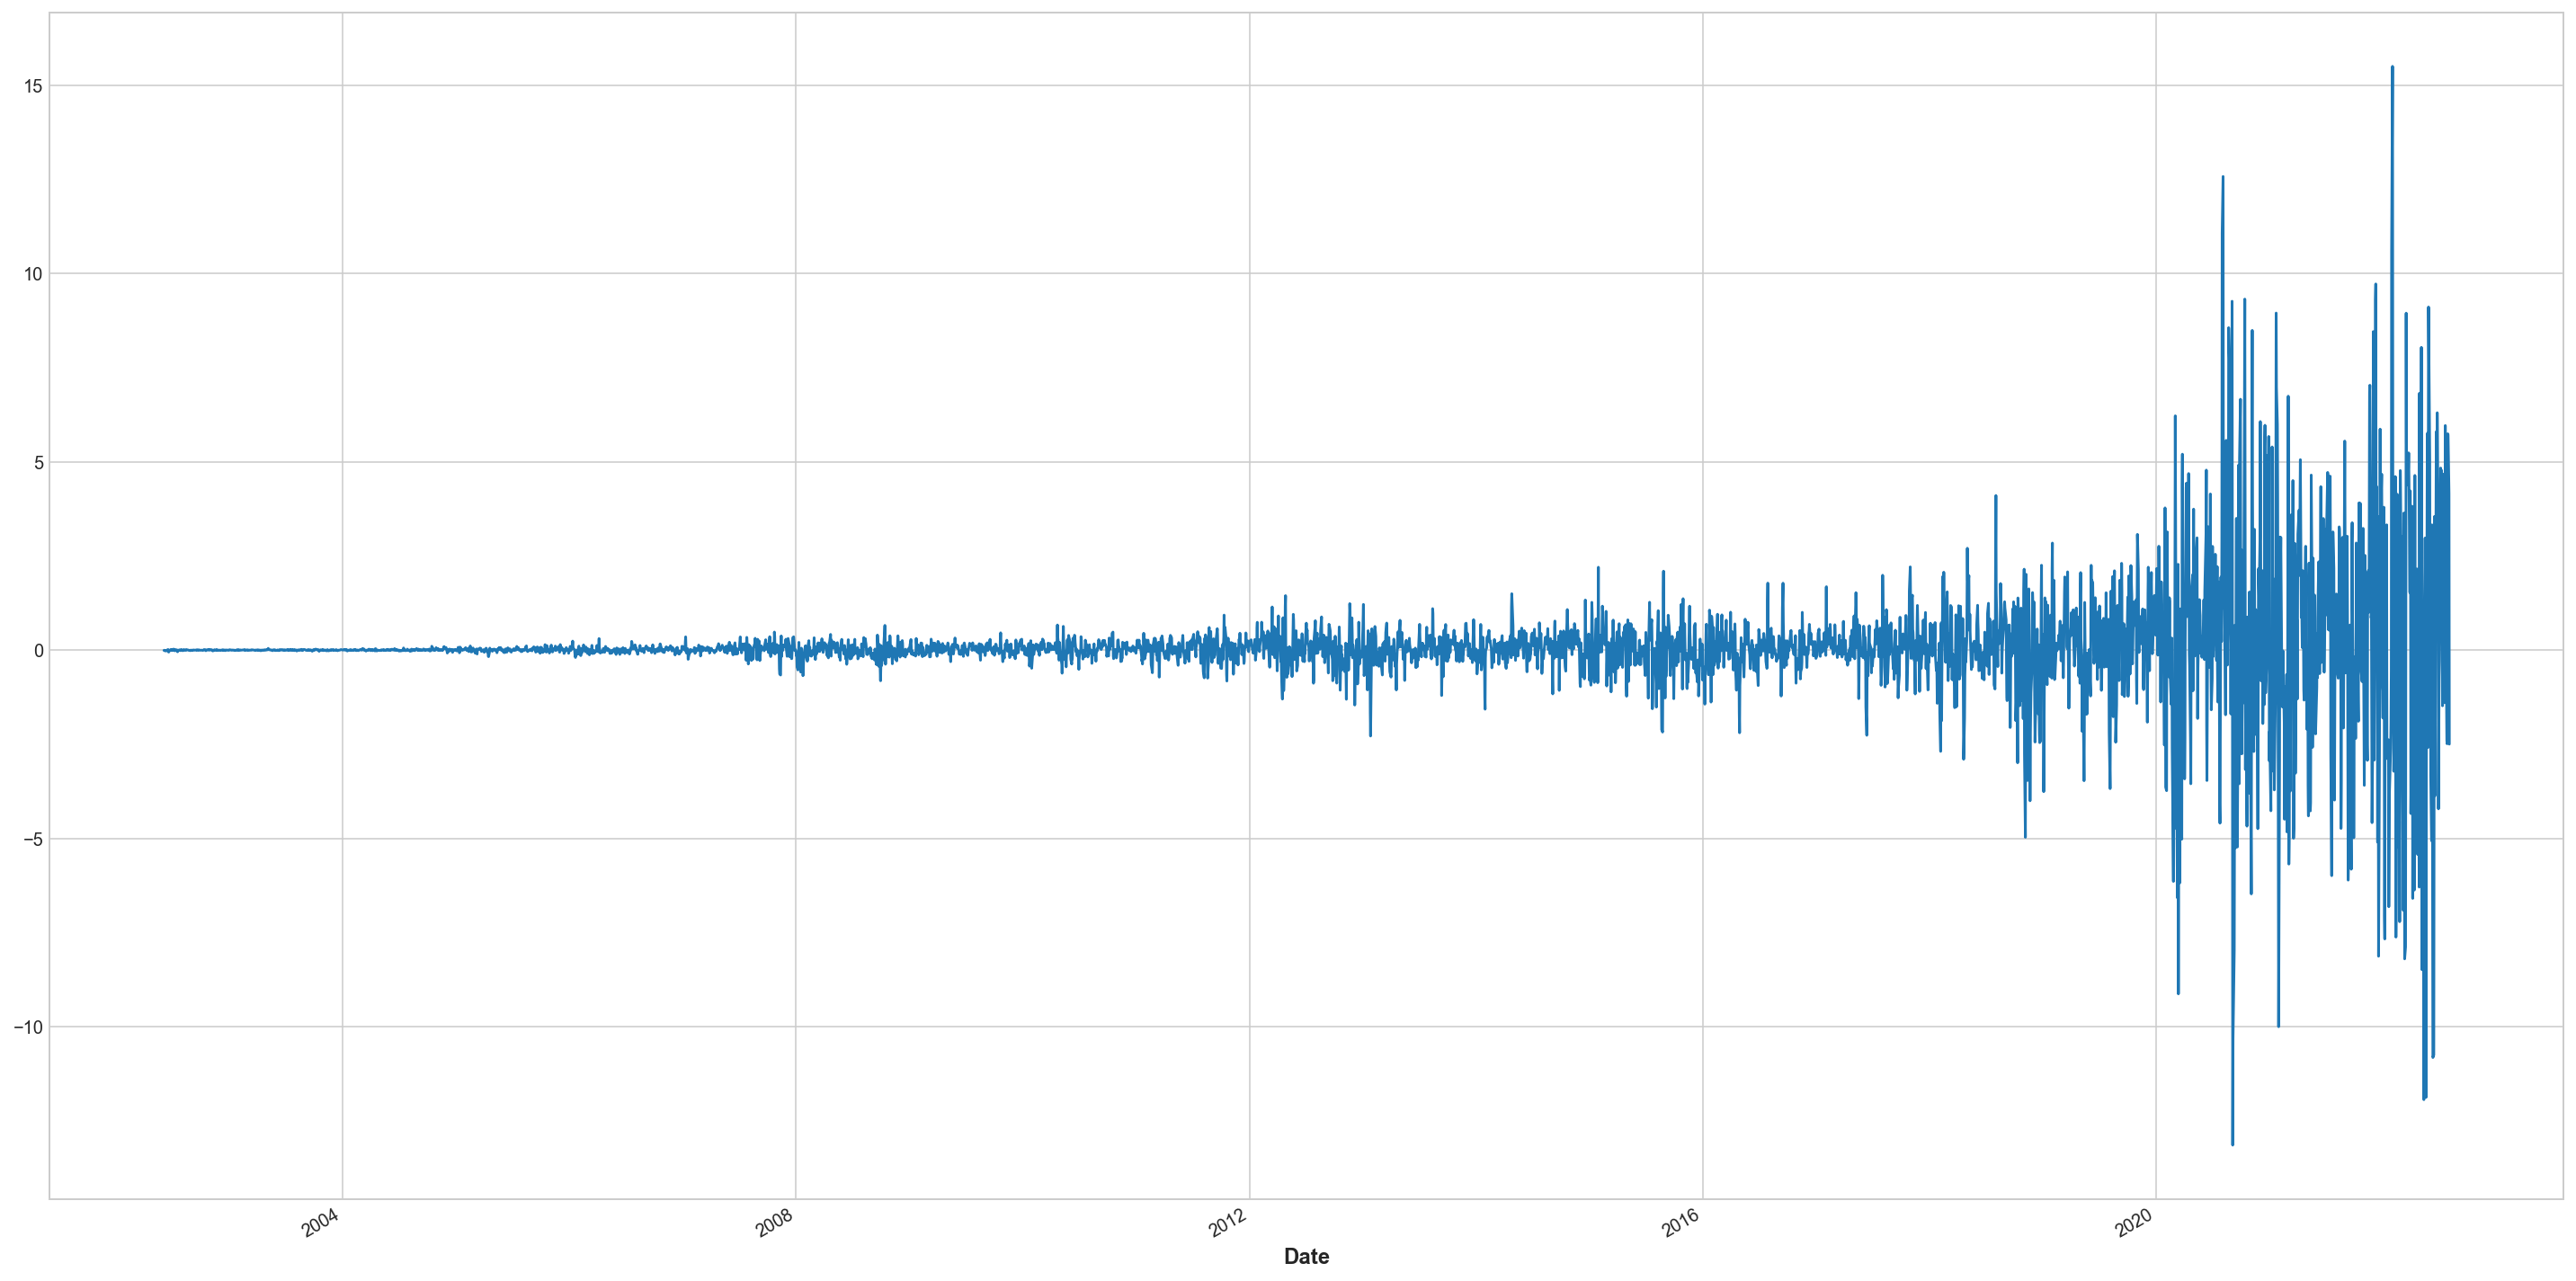

In [26]:
df=stock_data['diff_02']
df.plot()

In [27]:
ad_test(stock_data["diff_02"].dropna())

1. ADF:  -11.824904068581914
2. P-value:  8.247300398195464e-22
3. Number of lags:  33
4. Number of observations used for ADF regression and critical values calculation:  5043
5. Critical Values: 
	 1% :  -3.431647368966414
	 5% :  -2.8621132978691297
	 10% :  -2.567075166966035


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root (non-stationary) with the alternative that there is no unit root. With p-value = 8.247326567325672e-22, then we can reject H0.


#### Actually fit model

In [28]:
from statsmodels.tsa.arima.model import ARIMA

In [29]:
train_ar = stock_data_train['Adj Close'].values
test_ar = stock_data_prediction['Adj Close'].values


history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,2,0))
    model_fit = model.fit() # disp=0
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)


<class 'list'>


In [30]:
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
r2 = r2_score(test_ar, predictions)
print('R^2 score: %.3f' % r2)

Testing Mean Squared Error: 10.393
R^2 score: 0.932


In [31]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5078
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -7604.885
Date:                Tue, 30 Aug 2022   AIC                          15221.769
Time:                        17:11:49   BIC                          15260.963
Sample:                             0   HQIC                         15235.496
                               - 5078                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8887      0.005   -182.847      0.000      -0.898      -0.879
ar.L2         -0.7144      0.007   -109.018      0.000      -0.727      -0.702
ar.L3         -0.5586      0.006    -87.495      0.000      -0.571      -0.546
ar.L4         -0.3306      0.006    -54.185      0.000      -0.343      -0.319
ar.L5         -0.1292      0.005    -26.148      0.000      -0.139      -0.119
sigma2         1.1715      0.006    183.050      0.000       1.159       1.184
===================================================================================
Ljung-Box (L1) (Q):                   3.54   Jarque-Bera (JB):            132904.97
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):             561.91   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

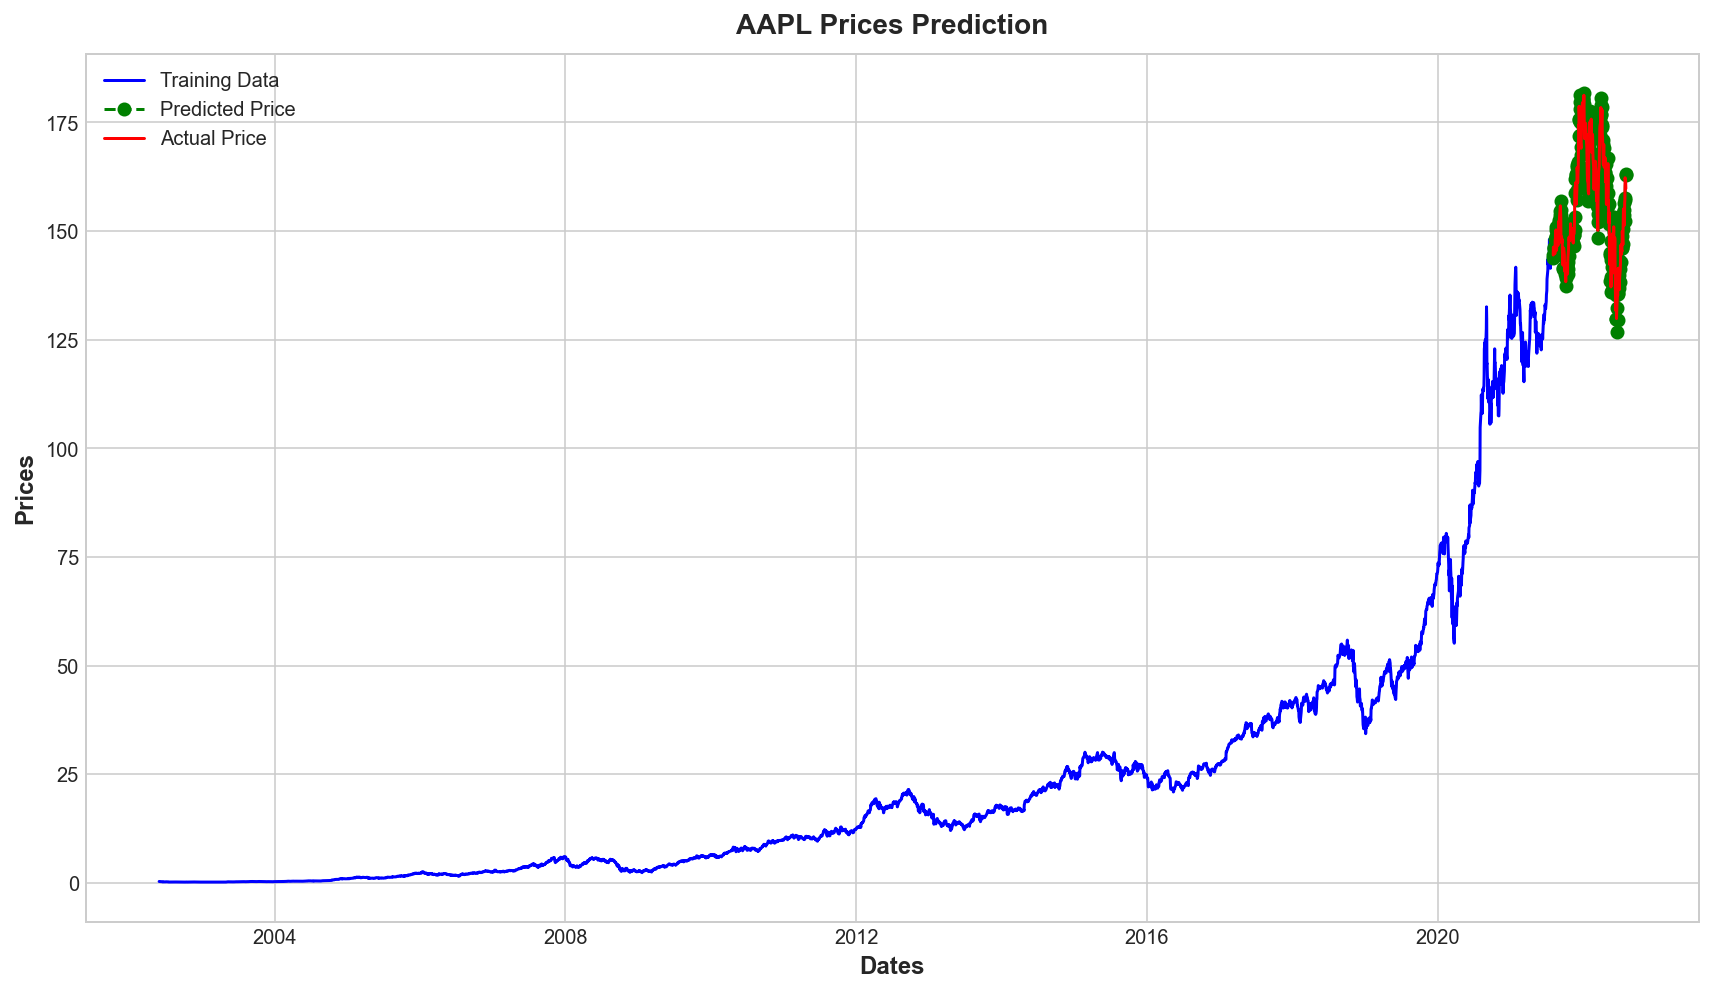

In [32]:
plt.figure(figsize=(12,7))
plt.plot(stock_data_train['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(stock_data_prediction.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(stock_data_prediction.index, stock_data_prediction['Adj Close'], color='red', 
         label='Actual Price')
plt.title('AAPL Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

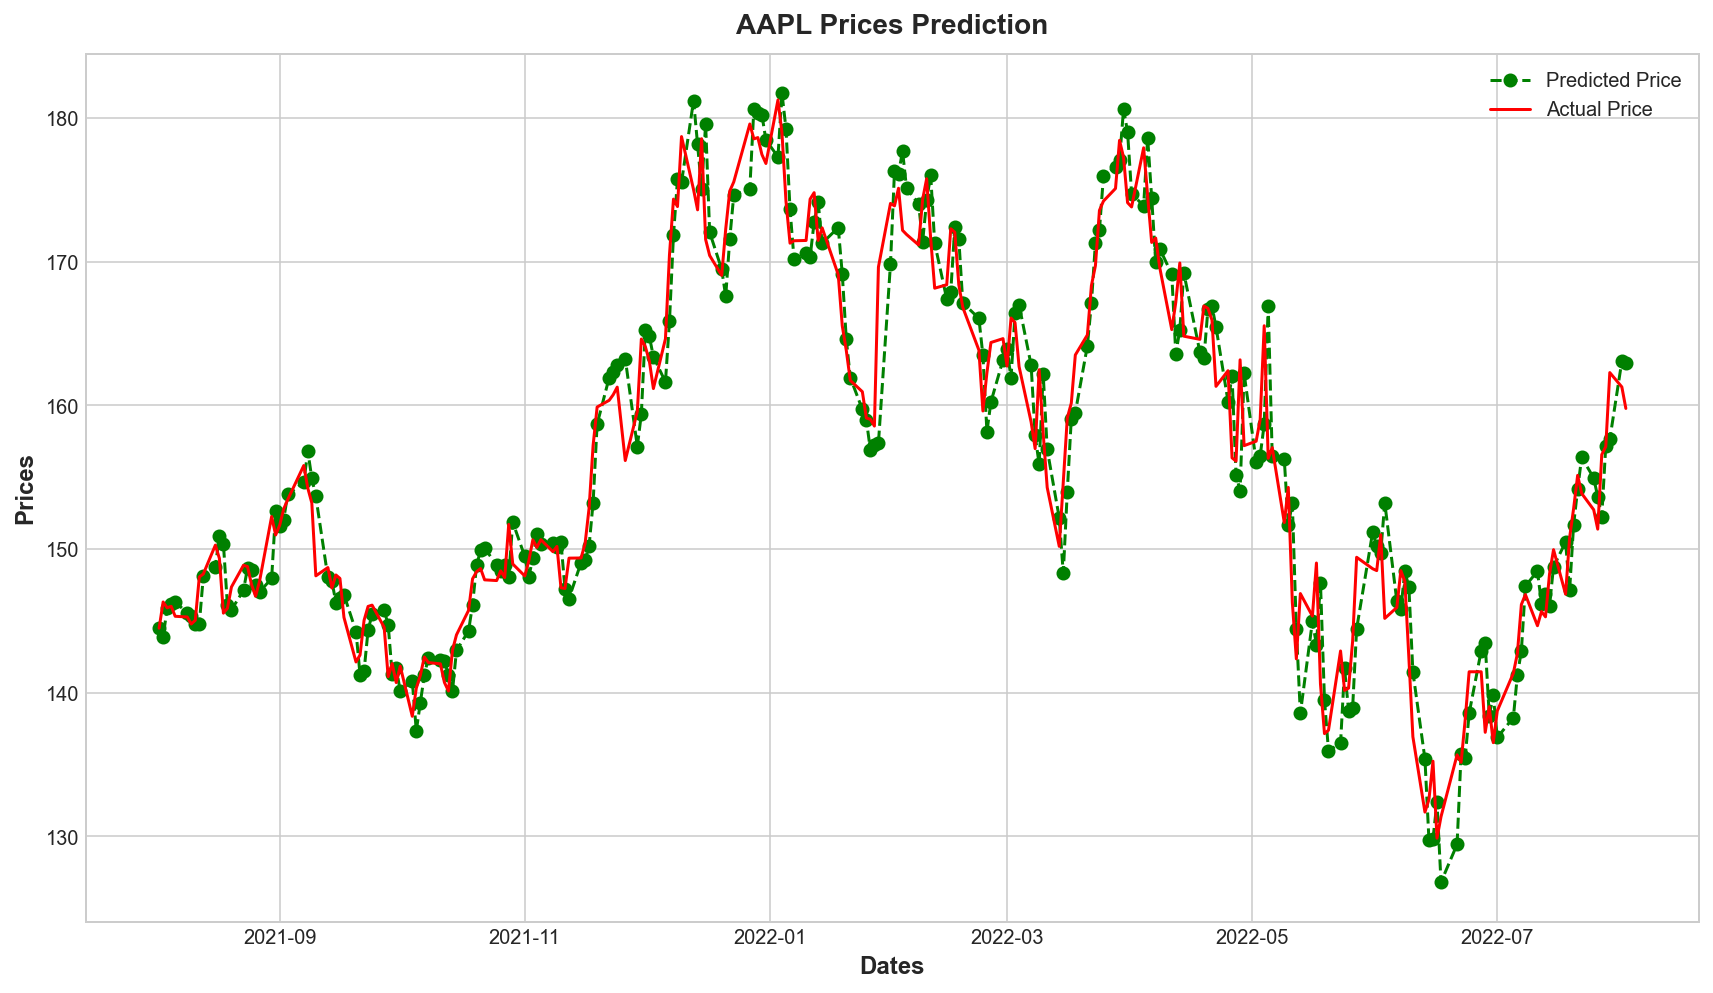

In [33]:
plt.figure(figsize=(12,7))
plt.plot(stock_data_prediction.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(stock_data_prediction.index, stock_data_prediction['Adj Close'], color='red', 
         label='Actual Price')
plt.title('AAPL Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

In [3]:
start_date = dt.date(2002,6,1)
end_date = dt.date(2022,8,3)
df = yf.download('AAPL',start_date,end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
series = df['Adj Close']

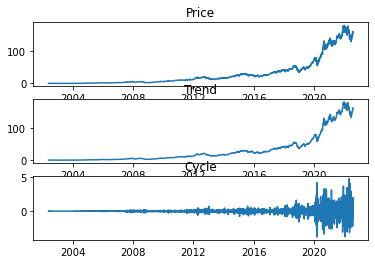

In [5]:
# use the decomposition methods to help improve our predictive abilities? 

cycle, trend = sm.tsa.filters.hpfilter(series, 1)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

Test for trend MSE: 0.5359716522329856


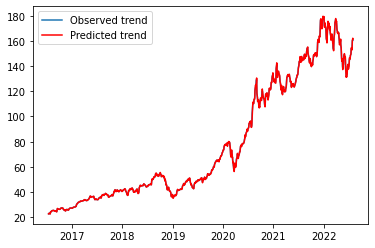

Test for cycle MSE: 0.7383106937456402


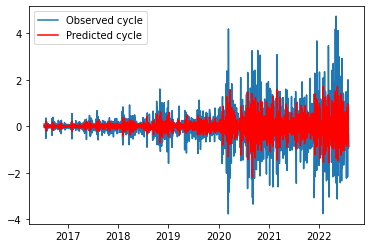

In [6]:
component_dict = {'cycle': cycle, 'trend': trend}
prediction_results = []
for component in ['trend', 'cycle']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(series) * 0.7):]
    predictions = []
    for i in range(len(test)):
        model = AR(historic, lags=2)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

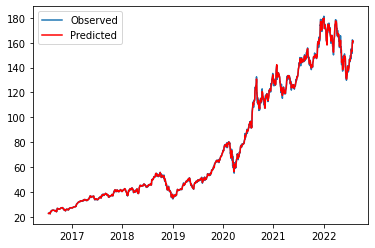

RMSE: 0.752926362928413


In [7]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
recomposed_preds.name = 'recomposed_preds'
series=df['Adj Close']
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()
test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

# STL Decomposition method for forcasting

In [8]:
series=df['log Adj Close']

KeyError: 'log Adj Close'

## Method 4:  Monte Carlo Simulation

As a stock investor, people always try to find the effective way to predict the future price of stocks. **Random Walk Theory** suggests that:
>Changes in stock price have the same distribution and are independent of each other. Therefore, it assumes the past movement or trend of a stock price or market cannot be used to predict its future movement." (*source*: [Investopedia](https://www.investopedia.com/terms/r/randomwalktheory.asp)).


### 1. General description

Generally speaking, a Monte Carlo simulation is a mathematical numerical method of making predictions by repeatedly running models that have random variables and aggregating all the results to understand the range of outcomes.

We will see that each trajectory will be slightly different , so we can make multiple forecasts and aggregate all the results to see overall range of potential price changes within the time horizon.

It's not difficult to recognize the random walk pattern from our graph. The stock price prediction problem is considered as Markov process - "memorylessness" (a.k.a a particular stochastic process independent of its history: the future movements of stock price rely on the current price; its future and past states are independent.)
Looking at the graph, we need a model that takes into account both types of movements in the stock price. Geometric Brownian Motion has 2 components to meet these requirements: One component incorporates the long-term trend while the other component applies random shocks.

However, before dive into Geometric Brownian Motion, let's look at the components that this process is built from.

### The standard Brownian motion

A standard Brownian (or a standard Wiener process) is a sctochastic process {$W_{t}$} (that is, a family of random variables $W_{t}$), defined on a common probability space ($\Omega$,: $\mathfrak{F}$ ,$\mathcal{P}$) with the following properties:
1. $W_{0}$ = 0
2. With probability 1, the function t $\rightarrow$ $W_{t}$ is continuos in t.
3. The process {$W_{t}$} has stationary, independent increments across time.
4. The increment $W_{t+s}$ - $W_{s}$ follows a normal (Gaussian) probability distribution law $\mathcal{N}$(0,t)

If $\varepsilon$ is a standard normal variable $\mathcal{N}$(0,1), this can be written as:

<center>$\Delta$$\mathcal{z}$ = $\varepsilon$$\sqrt{\Delta\mathcal{t}}$</center>

A standard Brownian motion is a martingale.


### The generalized Wiener process

A Wiener process has a drift rate (i.e. average change per unit time) of 0 and a variance rate of 1. In a generalized Wiener process the drift rate and the variance rate can be set equal to any chosen constants. This describes a variable $\Delta$$\mathcal{x}$ built up from a Wiener process, with in addition ***a*** constant trend a per unit time and volatility ***b***:

<center>$\Delta$$\mathcal{x}$ = $\mathcal{a}$$\Delta$$\mathcal{t}$ + $\mathcal{b}$$\Delta$$\mathcal{z}$</center>


### The Ito process 

This process describes a generalized Wiener process whose trend and volatility depend on the current value of the underlying variable and time:

<center>$\Delta$$\mathcal{x}$ = $\mathcal{a(X,t)} \Delta \mathcal{t} + \mathcal{b(X,t)} \Delta \mathcal{z}$</center>

As an application of Ito Lemma (Ito Calculus), ***Geometrical Brownian Motion*** has been applied popularly in the time-evoluation of an asset price S(t). A standard Brownian motion cannot be used as a model here, since there is a non-zero probability of the price becoming negative. A geometric Brownian motion is used instead, where the logarithm of the stock price has stochastic behaviour.

In the standard Black-Sholes model the price of an underlying asset S(t) is modelised by supposing that S verifies the following stochastic differential equation:

<center>$\mathcal{dS} = \hat{\mu} \mathcal{Sdt} + \hat{\sigma} \mathcal{SdW}$</center>

Where: $\hat{\mu} \mathcal{S} = \mu\mathcal{(S,t)}$ and $\hat{\sigma} \mathcal{S} = \sigma\mathcal{(S,t)}$

Put ${Y}  = ln \mathcal{S} $ and apply Ito Lemma, we get:

<center>$\mathcal{d}{Y} = (\hat{\mu} - \frac{\hat{\sigma}^2}2)\mathcal{dt}  + \hat{\sigma} \mathcal{dW}$</center>

By direct integration we have:

<center>${Y(t)} = {Y(0)} + (\hat{\mu} - \frac{\hat{\sigma}^2}2)) {t} + \hat{\sigma} {W(t)}$</center>
or
<center>$ln{S(t)} = {ln S(0)} + (\hat{\mu} - \frac{\hat{\sigma}^2}2)) {t} + \hat{\sigma} {W(t)}$</center>

The random variable ${Y(t) - Y(0)} \equiv ln( \frac{S(t)}{S(0)})$ follows a Gaussian law with parameters:
* Expectation value:

<center>${m_{t}} = (\hat{\mu} - \frac{\hat{\sigma}^2}2) {t} $</center>

because $({W(t)} - {W(0)}$ centered,
* Variance:

<center>${Var(Y)} = \hat{\sigma}^2 {t}$</center>

because ${Var[\hat{\sigma}[W(t)-W(0)]] = \hat{\sigma}^2 t}$ (*Diffusion integrals' properties*)

As a result, the asset ${S_{t}}$ follows the **lognormal** law of probability parameters:


<center>${m_{t}} = (\hat{\mu} - \frac{\hat{\sigma}^2}2) {t}; \quad \sigma^2_{t} = \hat{\sigma}^2 {t} $</center>

We call {${S_{t}}$} **Geometrical Brownian Motion**.

#### Single simulation

In [34]:
print(stock_data_prediction.shape[0])

253


In [35]:
returns = stock_data_train['Adj Close'].pct_change()
daily_vol = returns.std()

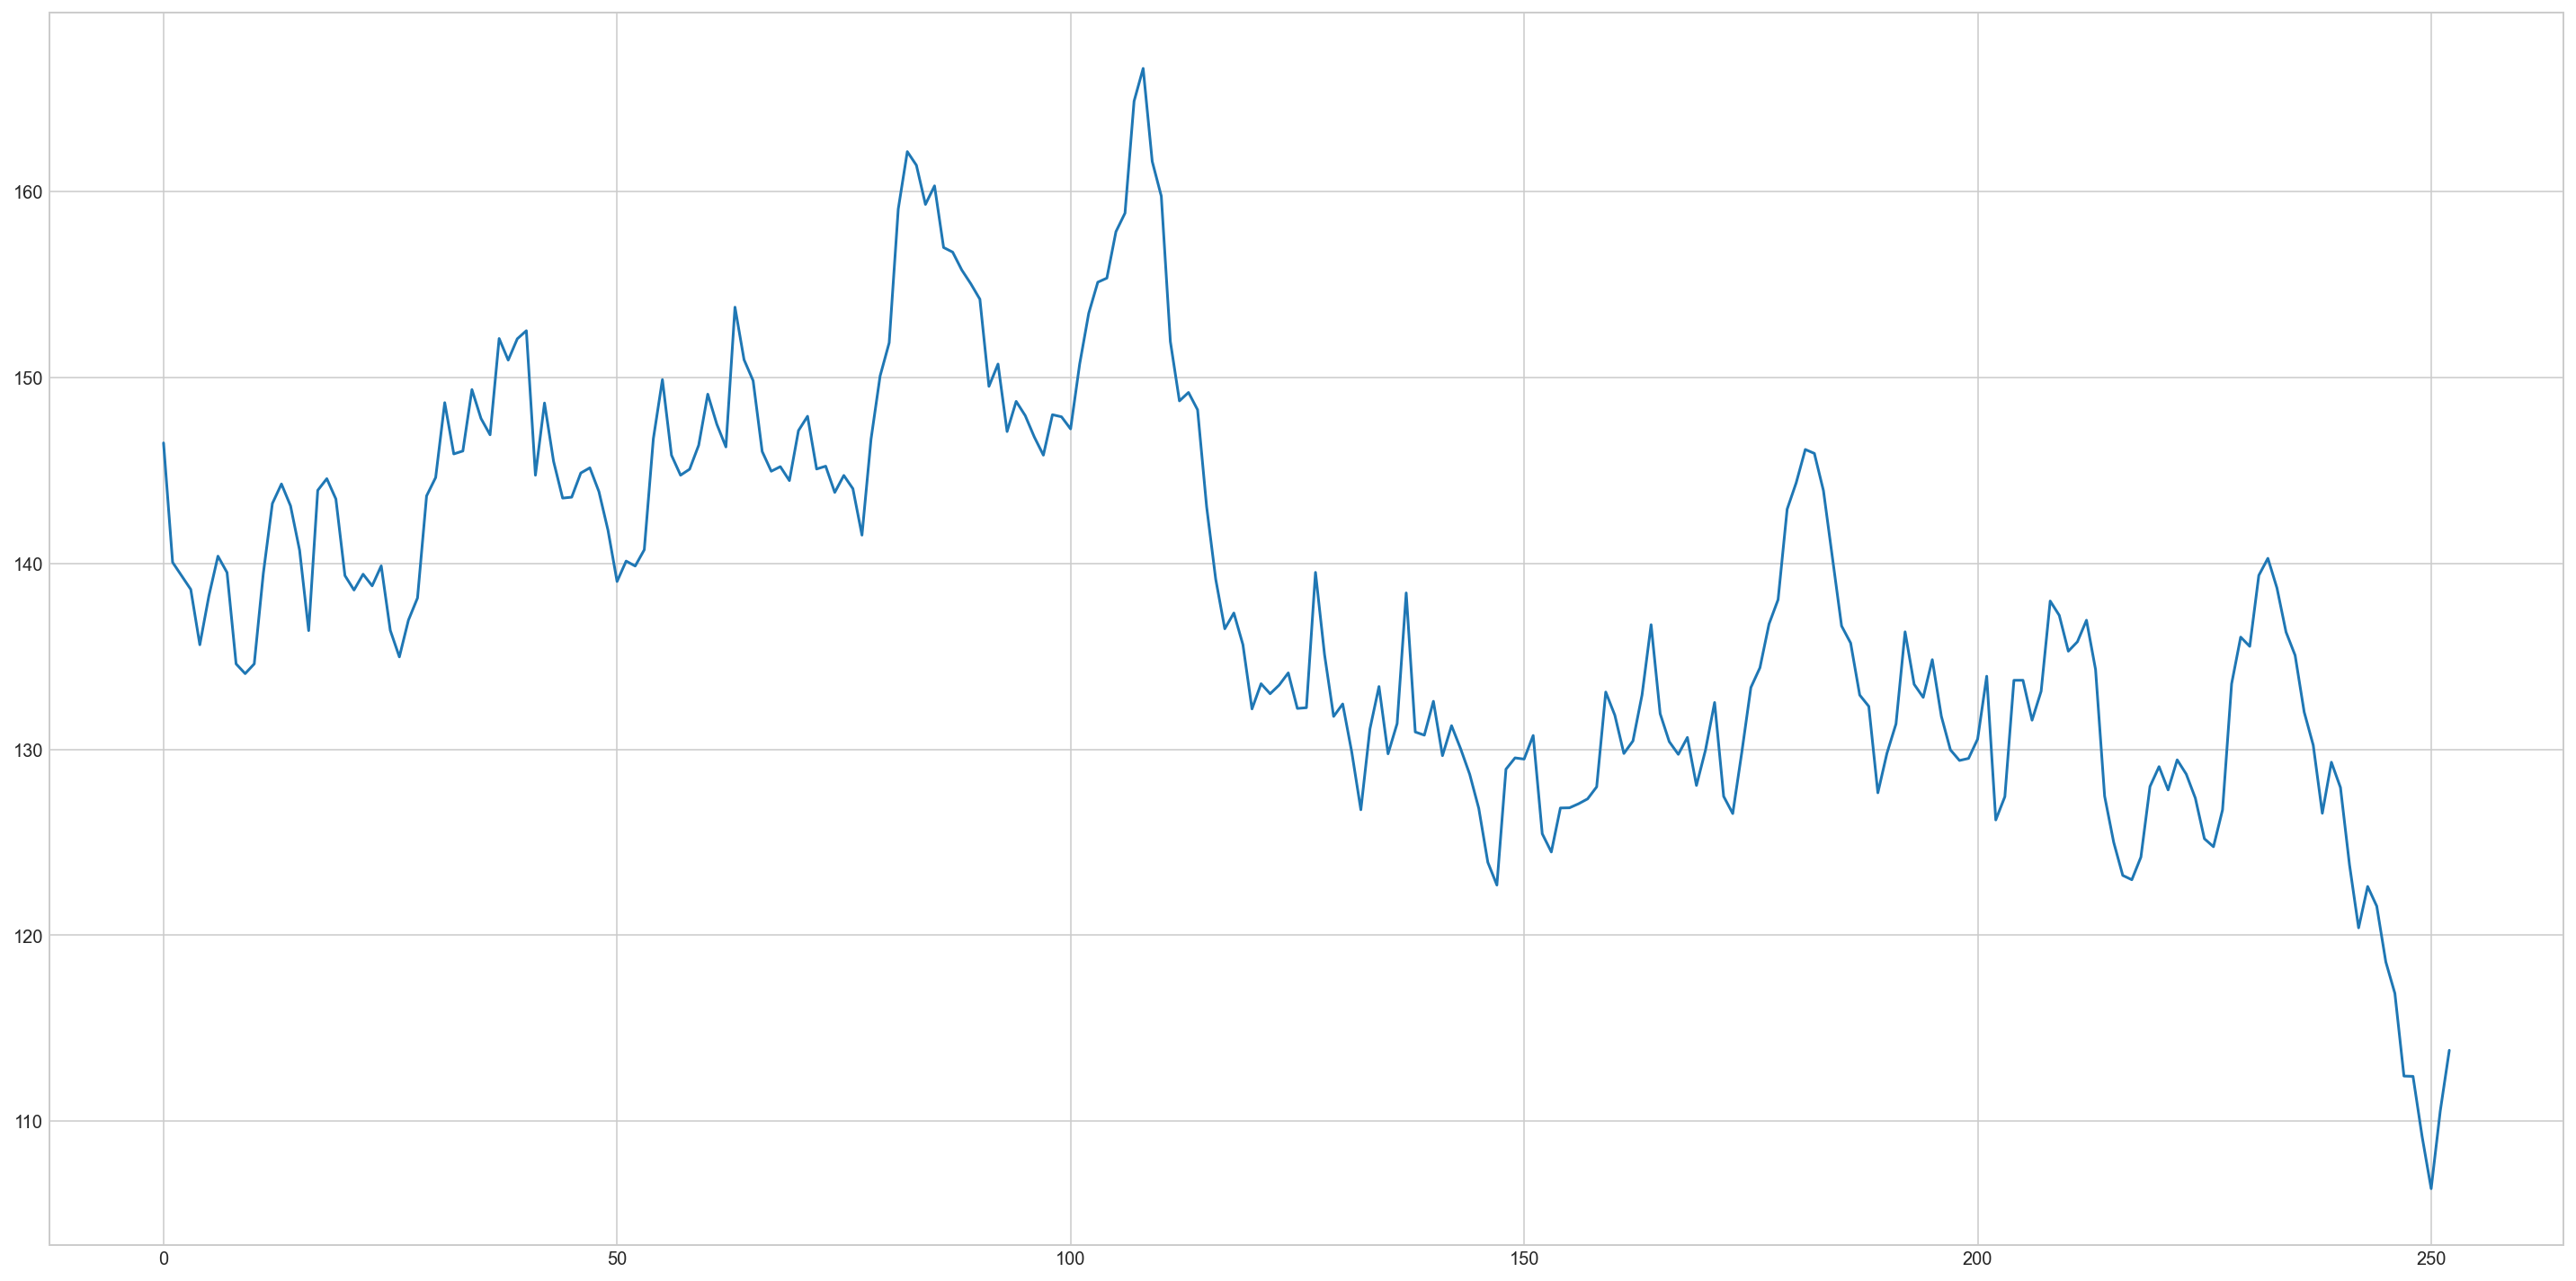

In [36]:
T = 253
count = 0
price_list = []
last_price = stock_data_train['Adj Close'][-1]

price = last_price * (1 + np.random.normal(0, daily_vol))
price_list.append(price)

for y in range(T):
    if count == T-1:
        break
    price = price_list[count]* (1 + np.random.normal(0, daily_vol))
    price_list.append(price)
    count += 1

plt.plot(price_list)
plt.show()

#### Multiple simulation

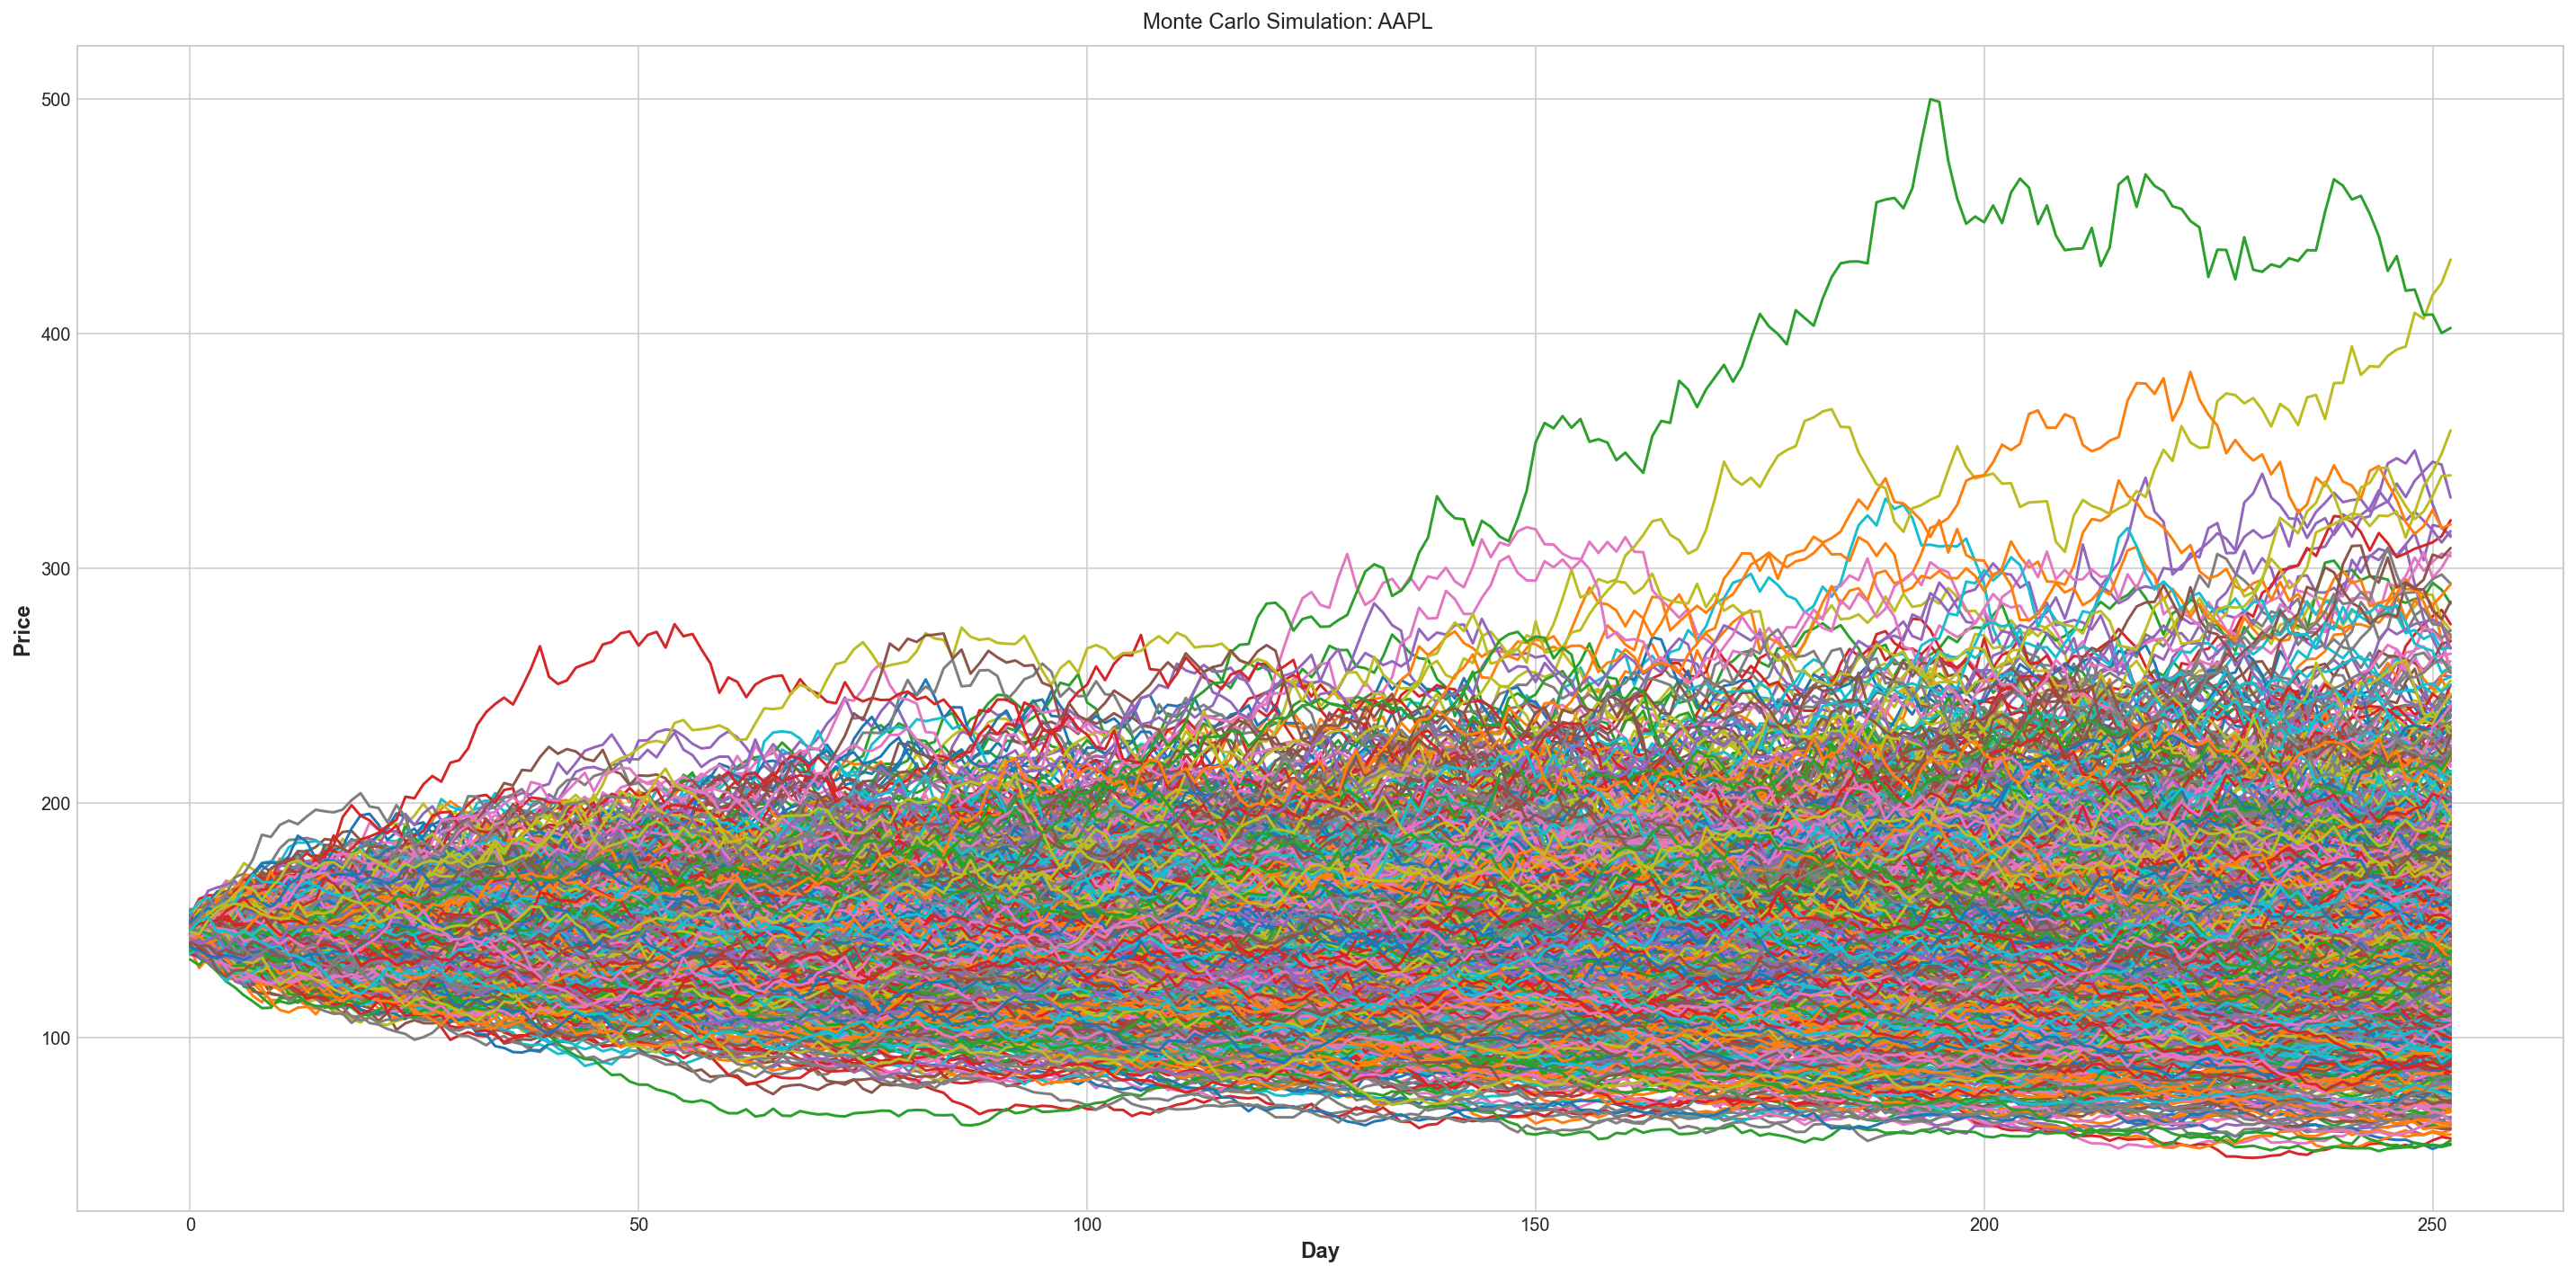

In [37]:
NUM_SIMULATIONS =  1000
df = pd.DataFrame()
last_price_list = []
for x in range(NUM_SIMULATIONS):
    count = 0
    price_list = []
    price = last_price * (1 + np.random.normal(0, daily_vol))
    price_list.append(price)
    
    for y in range(T):
        if count == T-1:
            break
        price = price_list[count]* (1 + np.random.normal(0, daily_vol))
        price_list.append(price)
        count += 1
        
    df[x] = price_list
    last_price_list.append(price_list[-1])
        
fig = plt.figure()
fig.suptitle("Monte Carlo Simulation: AAPL")
plt.plot(df)
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [38]:
print("Expected price: ", round(np.mean(last_price_list),2))
print("Quantile (5%): ",np.percentile(last_price_list,5))
print("Quantile (95%): ",np.percentile(last_price_list,95))

Expected price:  146.18
Quantile (5%):  78.95823489757335
Quantile (95%):  241.12945985262482


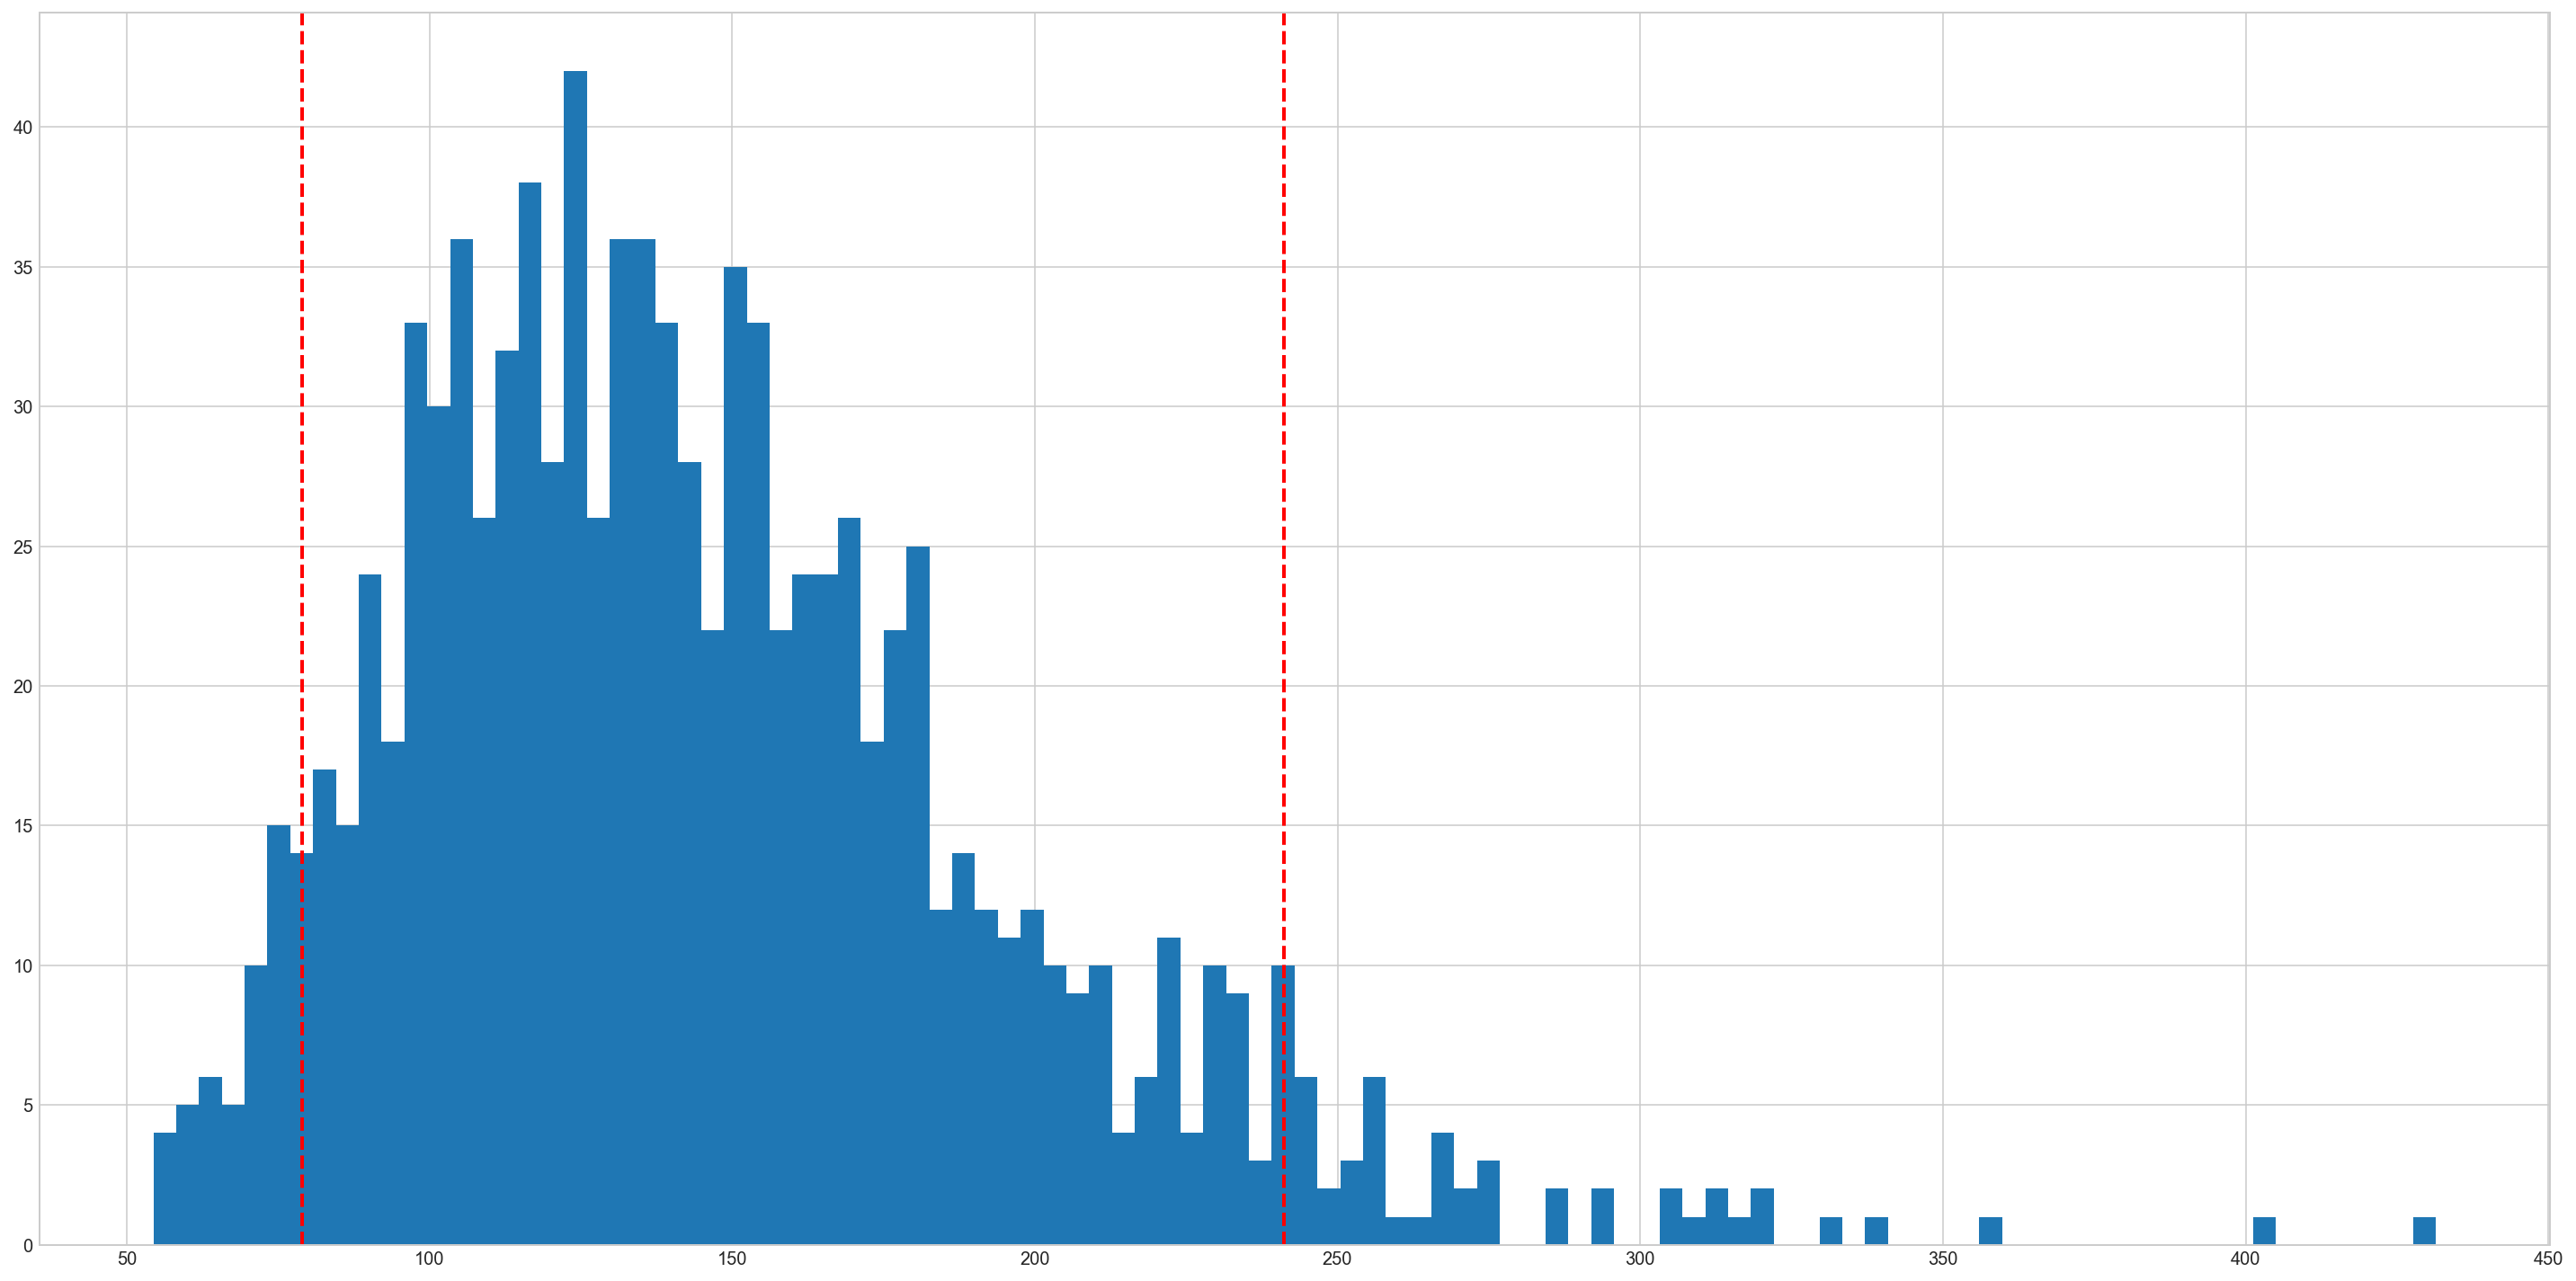

In [39]:
plt.hist(last_price_list,bins=100)
plt.axvline(np.percentile(last_price_list,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(last_price_list,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

## Interesting patterns in the real dataset

From the beginning of 2019 until now, it's the time of COVID pandemic, which has many effects to the global economy. Let's extract and draw the stock data graph  of AAPL from Jan.2019 until now to find out some meaningful insights.

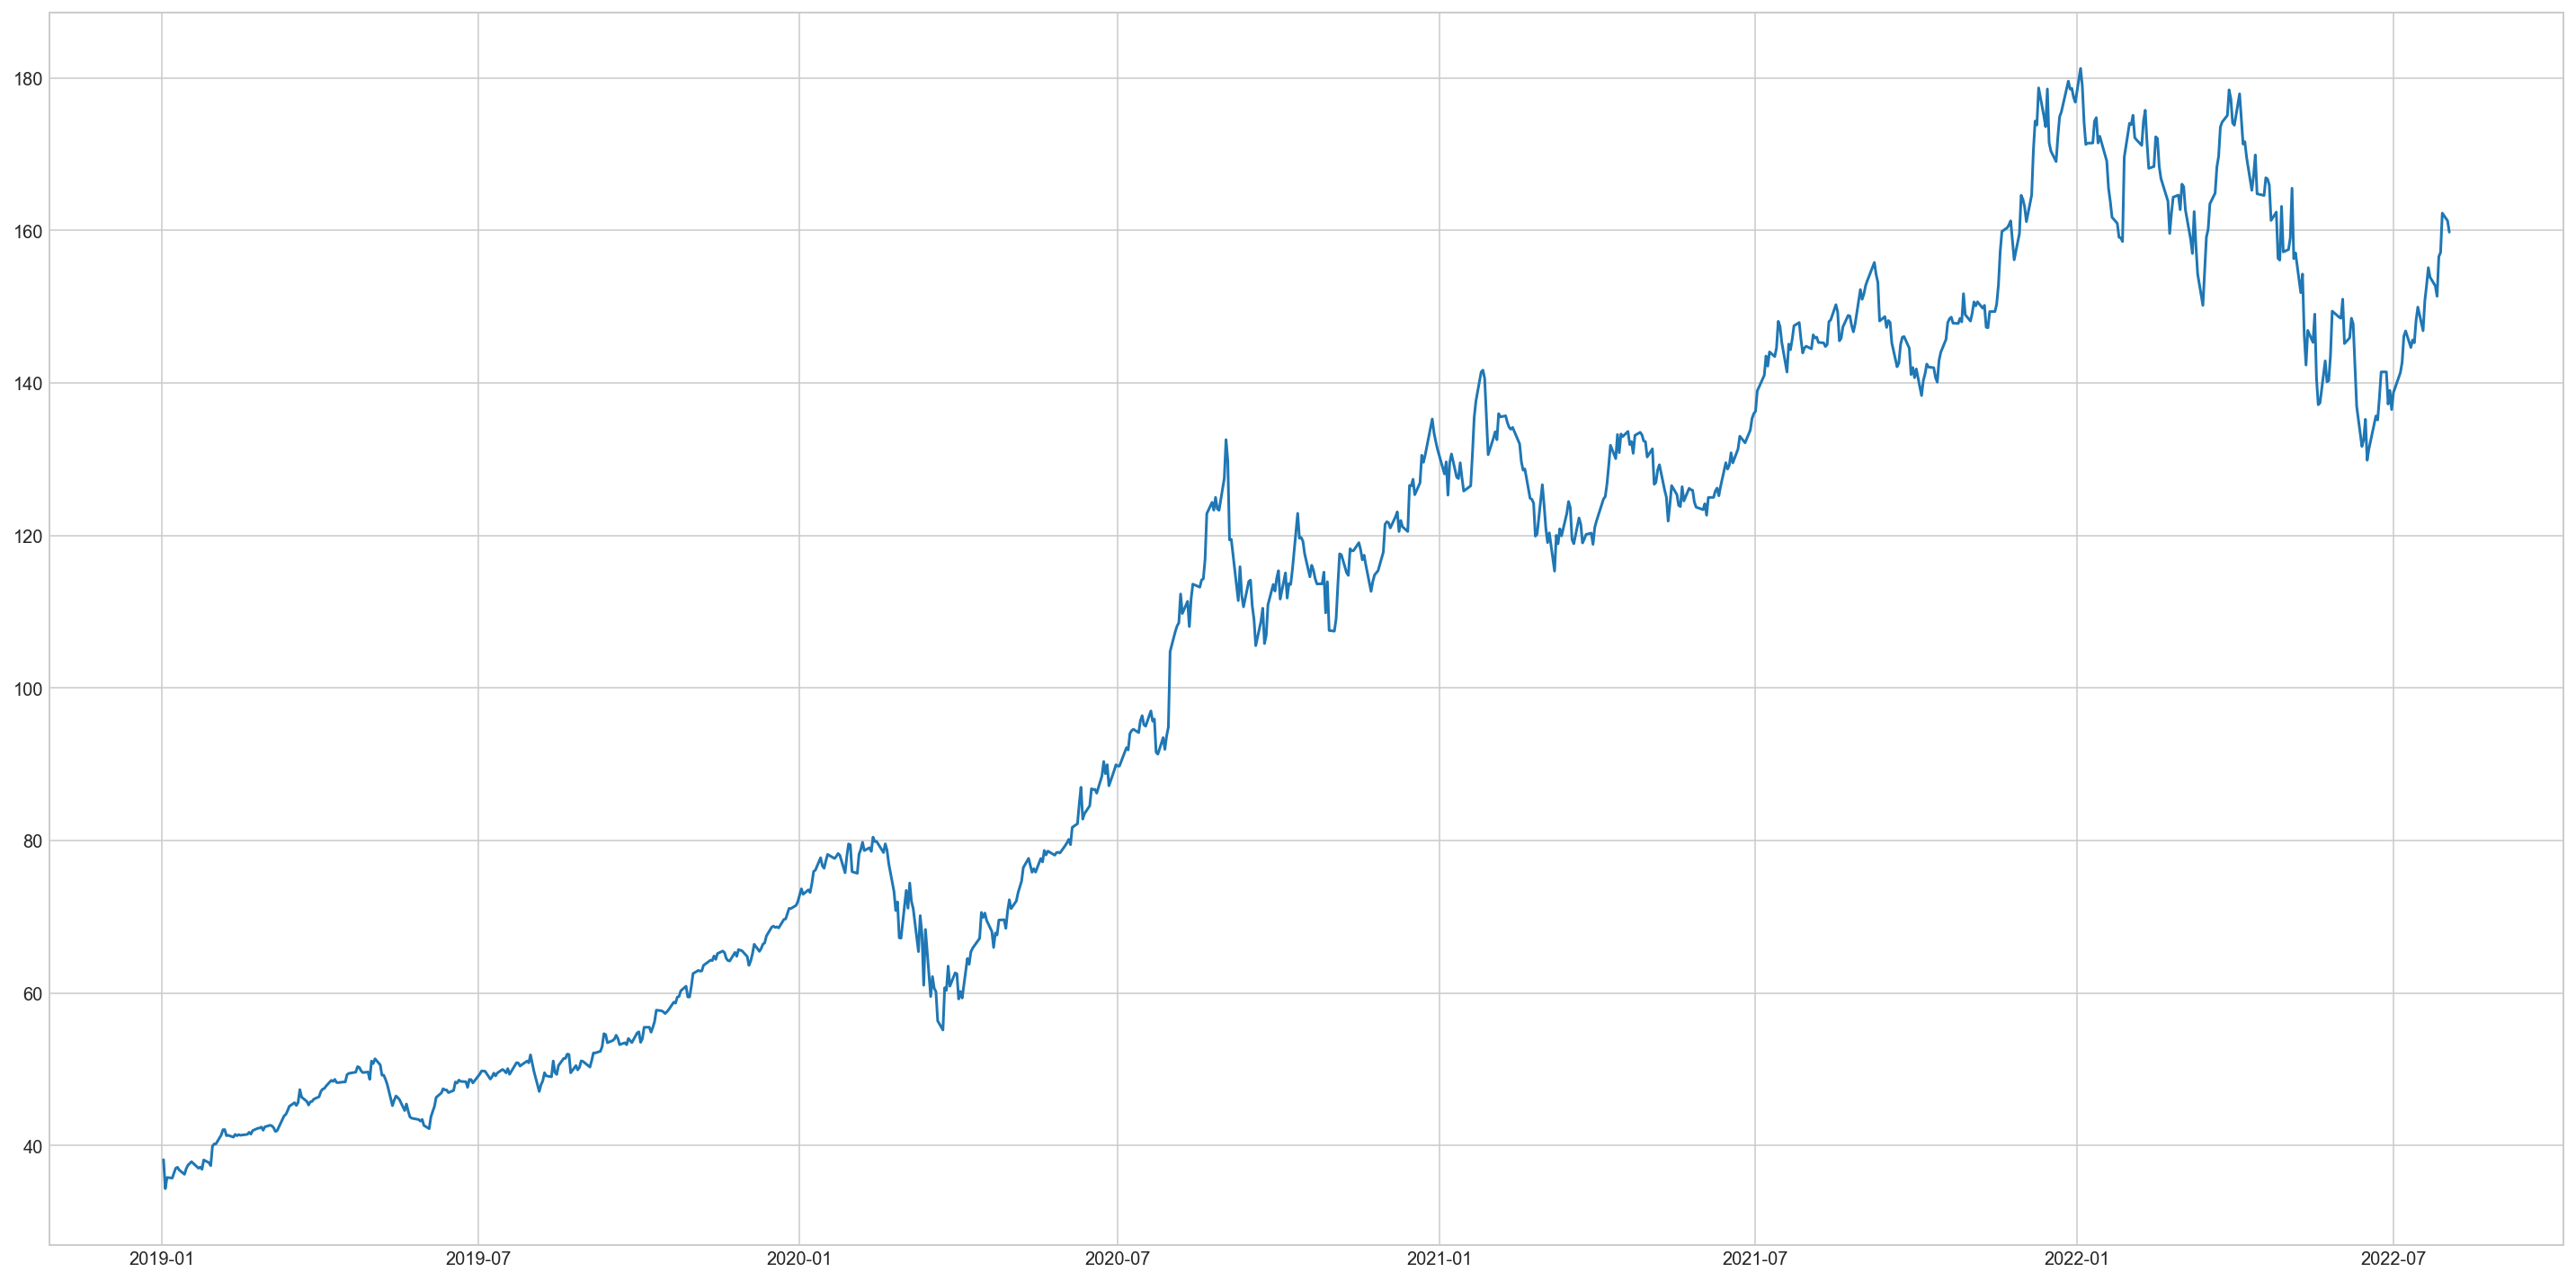

In [40]:
stock_data_covid = stock_data.loc['2019-01-01':,:]
plt.plot(stock_data_covid['Adj Close'])

Apple Inc. is one of the US 5 Big Tech (FAANG), hence, it is reasonal to compare how COVID has different impacts on these company.

In [41]:
start_covid = dt.date(2019,1,1)
end_covid = dt.date(2022,8,3)

# META (Facebook) stock price
meta = yf.download('META',start_covid,end_covid)
meta = meta['Adj Close']
# AMZN (Amazon) stock price
amzn = yf.download('AMZN',start_covid,end_covid)
amzn = amzn['Adj Close']
# NFLX (Netflix) stock price
nflx = yf.download('NFLX',start_covid,end_covid)
nflx = nflx['Adj Close']
# GOOGL (GOOGLE) stock price
googl = yf.download('GOOGL',start_covid,end_covid)
googl = googl['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


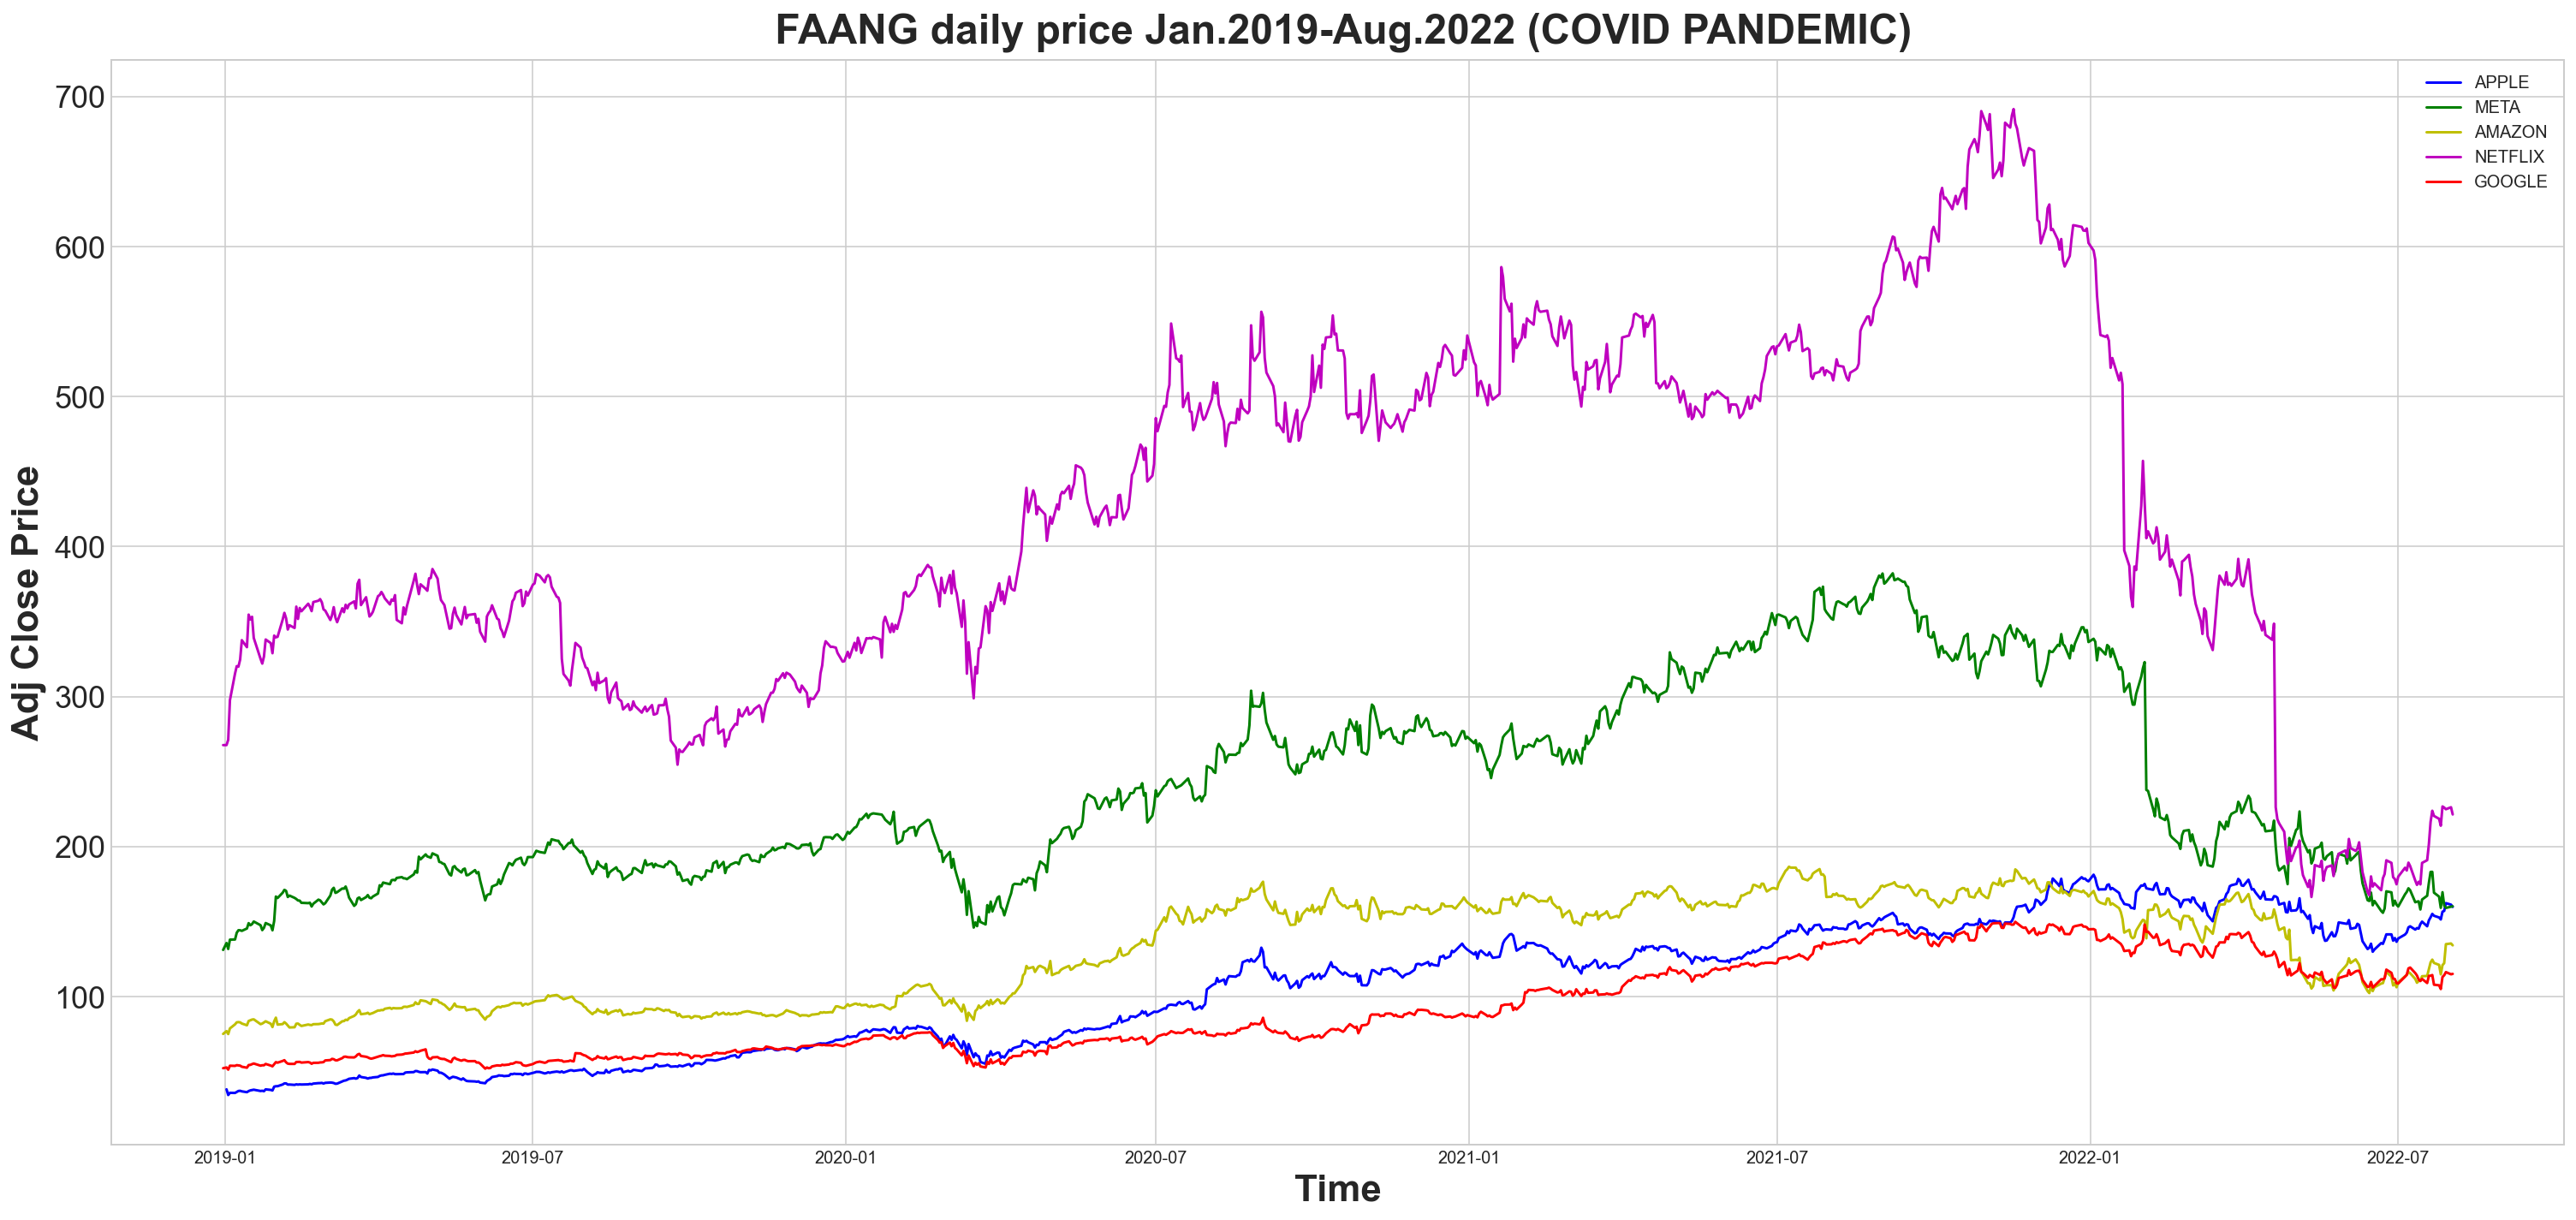

In [42]:
plt.figure(figsize=(21, 10))
plt.title(' FAANG daily price Jan.2019-Aug.2022 (COVID PANDEMIC)', fontsize=24)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Adj Close Price', fontsize=22)
plt.yticks(fontsize=18)

# stock_data_train['Adj Close'].plot()
# stock_data_prediction['Adj Close'].plot()
plt.plot(stock_data_covid['Adj Close'], color='b', label='APPLE')
plt.plot(meta, color='g', label='META')
plt.plot(amzn, color='y', label='AMAZON')
plt.plot(nflx, color='m', label='NETFLIX')
plt.plot(googl, color='r', label='GOOGLE')

plt.legend()
plt.show()

#### 2020 stock market crash

On 20 February 2020, stock markets across the world suddenly crashed after growing instability due to the COVID-19 pandemic. It ended on 7 April 2020. As we know, the new virus was first identified from an outbreak in Wuhan, China, in December 2019. However, in 2020, the COVID-19 pandemic, the most impactful pandemic since the Spanish flu, began decimating the economy. The World Health Organization (WHO) declared the outbreak a public health emergency of international concern on 30 January 2020 and a pandemic on 11 March 2020. Global economic shutdowns occurred due to the pandemic, and panic buying and supply disruptions exacerbated the market. The International Monetary Fund had pointed to other mitigating factors seen pre-pandemic, such as a global synchronized slowdown in 2019, as exacerbants to the crash, especially given that the market was already vulnerable.

The drop was caused by unbridled global fears about the spread of the coronavirus, oil price drops, and the possibility of a 2020 recession. However, optimism soon recovered. Over the preceding weekend, the Central Bank of Taiwan announced a T200 billion (6.6 billion) credit-line program to small and medium-sized businesses, while the Bank of Korea announced that it would conduct a 12 billion U.S. dollar-funding operation at auctions to South Korean banks. The South African Reserve Bank announced that it would ease banking accounting and capital regulations to release R300 billion in credit, while the Bank of Israel announced that it would ease its capital requirements to facilitate greater lending by its banking system as well.